In [1]:
import pdb
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axisartist.axislines import AxesZero

from dca.methods_comparison import JPCA #, symmJPCA
#from pyuoi.linear_model.var  import VAR
from neurosim.models.var import form_companion

import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes
from segmentation import reach_segment_sabes, measure_straight_dev

# Load Data Structures

In [2]:
dimreduc_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output/dimreduc_clear_final_analysis_230322_214006_Jamie/dimreduc_clear_final_analysis_230322_214006_Jamie_glom.pickle'
with open(dimreduc_glom_path, 'rb') as f:
    dat = pickle.load(f) 
df_dimreduc = pd.DataFrame(dat)

paradigm_session_name = os.path.splitext(os.path.basename(dimreduc_glom_path))[0]

In [3]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_dimreduc['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)

In [4]:
for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)
                    AM_data_file = loaded_data_path


            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)
                    ML_data_file = loaded_data_path


AM_spikes = AM_loaded_data['spike_rates']
ML_spikes = ML_loaded_data['spike_rates']

## Plots and Analyses for Region AM

In [30]:
calcs = True
rot_trajectories = True
run_dyn_range = True
boxplots = True

In [31]:
curr_Region = 'AM'
DIM = 21
jDIM = DIM - 1 # must be even for jPCA 
LD_args = {'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'region': curr_Region, 'degraded': True}
data_files = [df_dimreduc['data_file'][0]]
dpath = AM_data_file

### Generate random projections used to for later comparison

In [32]:
inner_reps = 1000
random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'

if not os.path.exists(random_proj_path):
    resultsd3 = []
    for i, data_file in tqdm(enumerate(data_files)):
       
        dat = AM_loaded_data
        y = np.squeeze(dat['spike_rates'])

        for j in tqdm(range(inner_reps)):
            V = scipy.stats.special_ortho_group.rvs(y.shape[-1], random_state=np.random.RandomState(j))
            V = V[:, 0:DIM]
            # Project data
            yproj = y @ V

            # Segment reaches into minimum length 30 timesteps reaches
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])
            # yproj = gaussian_filter1d(yproj, sigma=5)

            result_ = {}
            result_['data_file'] = data_file
            result_['inner_rep'] = j

            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            # ypred = yproj[:-1, :] @ jpca.M_skew
            #r2_linear = linmodel.score(yproj[:-1, :], np.diff(yproj, axis=0))
            result_['jeig'] = jpca.eigen_vals_

            yprojcent = np.array([y_ - y_[0:1, :] for y_ in yproj])
            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)
            resultsd3.append(result_)


            print(f"Done with jPCA fit {j+1} of {inner_reps}.")

    with open(random_proj_path, 'wb') as f:
        f.write(pickle.dumps(resultsd3))            

print('Loading Existing Random Control')

0it [00:00, ?it/s]

Done with jPCA fit 1 of 1000.


Done with jPCA fit 2 of 1000.


Done with jPCA fit 3 of 1000.


Done with jPCA fit 4 of 1000.


Done with jPCA fit 5 of 1000.


Done with jPCA fit 6 of 1000.


Done with jPCA fit 7 of 1000.


Done with jPCA fit 8 of 1000.


Done with jPCA fit 9 of 1000.


Done with jPCA fit 10 of 1000.


Done with jPCA fit 11 of 1000.


Done with jPCA fit 12 of 1000.


Done with jPCA fit 13 of 1000.


Done with jPCA fit 14 of 1000.


Done with jPCA fit 15 of 1000.


Done with jPCA fit 16 of 1000.


Done with jPCA fit 17 of 1000.


Done with jPCA fit 18 of 1000.


Done with jPCA fit 19 of 1000.


Done with jPCA fit 20 of 1000.


Done with jPCA fit 21 of 1000.


Done with jPCA fit 22 of 1000.


Done with jPCA fit 23 of 1000.


Done with jPCA fit 24 of 1000.


Done with jPCA fit 25 of 1000.


Done with jPCA fit 26 of 1000.


Done with jPCA fit 27 of 1000.


Done with jPCA fit 28 of 1000.


Done with jPCA fit 29 of 1000.


Done with jPCA fit 30 of 1000.


Done with jPCA fit 31 of 1000.


Done with jPCA fit 32 of 1000.


Done with jPCA fit 33 of 1000.


Done with jPCA fit 34 of 1000.


Done with jPCA fit 35 of 1000.


Done with jPCA fit 36 of 1000.


Done with jPCA fit 37 of 1000.


Done with jPCA fit 38 of 1000.


Done with jPCA fit 39 of 1000.


Done with jPCA fit 40 of 1000.


Done with jPCA fit 41 of 1000.


Done with jPCA fit 42 of 1000.


Done with jPCA fit 43 of 1000.


Done with jPCA fit 44 of 1000.


Done with jPCA fit 45 of 1000.


Done with jPCA fit 46 of 1000.


Done with jPCA fit 47 of 1000.


Done with jPCA fit 48 of 1000.


Done with jPCA fit 49 of 1000.


Done with jPCA fit 50 of 1000.


Done with jPCA fit 51 of 1000.


Done with jPCA fit 52 of 1000.


Done with jPCA fit 53 of 1000.


Done with jPCA fit 54 of 1000.


Done with jPCA fit 55 of 1000.


Done with jPCA fit 56 of 1000.


Done with jPCA fit 57 of 1000.


Done with jPCA fit 58 of 1000.


Done with jPCA fit 59 of 1000.


Done with jPCA fit 60 of 1000.


Done with jPCA fit 61 of 1000.


Done with jPCA fit 62 of 1000.


Done with jPCA fit 63 of 1000.


Done with jPCA fit 64 of 1000.


Done with jPCA fit 65 of 1000.


Done with jPCA fit 66 of 1000.


Done with jPCA fit 67 of 1000.


Done with jPCA fit 68 of 1000.


Done with jPCA fit 69 of 1000.


Done with jPCA fit 70 of 1000.


Done with jPCA fit 71 of 1000.


Done with jPCA fit 72 of 1000.


Done with jPCA fit 73 of 1000.


Done with jPCA fit 74 of 1000.


Done with jPCA fit 75 of 1000.


Done with jPCA fit 76 of 1000.


Done with jPCA fit 77 of 1000.


Done with jPCA fit 78 of 1000.


Done with jPCA fit 79 of 1000.


Done with jPCA fit 80 of 1000.


Done with jPCA fit 81 of 1000.


Done with jPCA fit 82 of 1000.


Done with jPCA fit 83 of 1000.


Done with jPCA fit 84 of 1000.


Done with jPCA fit 85 of 1000.


Done with jPCA fit 86 of 1000.


Done with jPCA fit 87 of 1000.


Done with jPCA fit 88 of 1000.


Done with jPCA fit 89 of 1000.


Done with jPCA fit 90 of 1000.


Done with jPCA fit 91 of 1000.


Done with jPCA fit 92 of 1000.


Done with jPCA fit 93 of 1000.


Done with jPCA fit 94 of 1000.


Done with jPCA fit 95 of 1000.


Done with jPCA fit 96 of 1000.


Done with jPCA fit 97 of 1000.


Done with jPCA fit 98 of 1000.


Done with jPCA fit 99 of 1000.


Done with jPCA fit 100 of 1000.


Done with jPCA fit 101 of 1000.


Done with jPCA fit 102 of 1000.


Done with jPCA fit 103 of 1000.


Done with jPCA fit 104 of 1000.


Done with jPCA fit 105 of 1000.


Done with jPCA fit 106 of 1000.


Done with jPCA fit 107 of 1000.


Done with jPCA fit 108 of 1000.


Done with jPCA fit 109 of 1000.


Done with jPCA fit 110 of 1000.


Done with jPCA fit 111 of 1000.


Done with jPCA fit 112 of 1000.


Done with jPCA fit 113 of 1000.


Done with jPCA fit 114 of 1000.


Done with jPCA fit 115 of 1000.


Done with jPCA fit 116 of 1000.


Done with jPCA fit 117 of 1000.


Done with jPCA fit 118 of 1000.


Done with jPCA fit 119 of 1000.


Done with jPCA fit 120 of 1000.


Done with jPCA fit 121 of 1000.


Done with jPCA fit 122 of 1000.


Done with jPCA fit 123 of 1000.


Done with jPCA fit 124 of 1000.


Done with jPCA fit 125 of 1000.


Done with jPCA fit 126 of 1000.


Done with jPCA fit 127 of 1000.


Done with jPCA fit 128 of 1000.


Done with jPCA fit 129 of 1000.


Done with jPCA fit 130 of 1000.


Done with jPCA fit 131 of 1000.


Done with jPCA fit 132 of 1000.


Done with jPCA fit 133 of 1000.


Done with jPCA fit 134 of 1000.


Done with jPCA fit 135 of 1000.


Done with jPCA fit 136 of 1000.


Done with jPCA fit 137 of 1000.


Done with jPCA fit 138 of 1000.


Done with jPCA fit 139 of 1000.


Done with jPCA fit 140 of 1000.


Done with jPCA fit 141 of 1000.


Done with jPCA fit 142 of 1000.


Done with jPCA fit 143 of 1000.


Done with jPCA fit 144 of 1000.


Done with jPCA fit 145 of 1000.


Done with jPCA fit 146 of 1000.


Done with jPCA fit 147 of 1000.


Done with jPCA fit 148 of 1000.


Done with jPCA fit 149 of 1000.


Done with jPCA fit 150 of 1000.


Done with jPCA fit 151 of 1000.


Done with jPCA fit 152 of 1000.


Done with jPCA fit 153 of 1000.


Done with jPCA fit 154 of 1000.


Done with jPCA fit 155 of 1000.


Done with jPCA fit 156 of 1000.


Done with jPCA fit 157 of 1000.


Done with jPCA fit 158 of 1000.


Done with jPCA fit 159 of 1000.


Done with jPCA fit 160 of 1000.


Done with jPCA fit 161 of 1000.


Done with jPCA fit 162 of 1000.


Done with jPCA fit 163 of 1000.


Done with jPCA fit 164 of 1000.


Done with jPCA fit 165 of 1000.


Done with jPCA fit 166 of 1000.


Done with jPCA fit 167 of 1000.


Done with jPCA fit 168 of 1000.


Done with jPCA fit 169 of 1000.


Done with jPCA fit 170 of 1000.


Done with jPCA fit 171 of 1000.


Done with jPCA fit 172 of 1000.


Done with jPCA fit 173 of 1000.


Done with jPCA fit 174 of 1000.


Done with jPCA fit 175 of 1000.


Done with jPCA fit 176 of 1000.


Done with jPCA fit 177 of 1000.


Done with jPCA fit 178 of 1000.


Done with jPCA fit 179 of 1000.


Done with jPCA fit 180 of 1000.


Done with jPCA fit 181 of 1000.


Done with jPCA fit 182 of 1000.


Done with jPCA fit 183 of 1000.


Done with jPCA fit 184 of 1000.


Done with jPCA fit 185 of 1000.


Done with jPCA fit 186 of 1000.


Done with jPCA fit 187 of 1000.


Done with jPCA fit 188 of 1000.


Done with jPCA fit 189 of 1000.


Done with jPCA fit 190 of 1000.


Done with jPCA fit 191 of 1000.


Done with jPCA fit 192 of 1000.


Done with jPCA fit 193 of 1000.


Done with jPCA fit 194 of 1000.


Done with jPCA fit 195 of 1000.


Done with jPCA fit 196 of 1000.


Done with jPCA fit 197 of 1000.


Done with jPCA fit 198 of 1000.


Done with jPCA fit 199 of 1000.


Done with jPCA fit 200 of 1000.


Done with jPCA fit 201 of 1000.


Done with jPCA fit 202 of 1000.


Done with jPCA fit 203 of 1000.


Done with jPCA fit 204 of 1000.


Done with jPCA fit 205 of 1000.


Done with jPCA fit 206 of 1000.


Done with jPCA fit 207 of 1000.


Done with jPCA fit 208 of 1000.


Done with jPCA fit 209 of 1000.


Done with jPCA fit 210 of 1000.


Done with jPCA fit 211 of 1000.


Done with jPCA fit 212 of 1000.


Done with jPCA fit 213 of 1000.


Done with jPCA fit 214 of 1000.


Done with jPCA fit 215 of 1000.


Done with jPCA fit 216 of 1000.


Done with jPCA fit 217 of 1000.


Done with jPCA fit 218 of 1000.


Done with jPCA fit 219 of 1000.


Done with jPCA fit 220 of 1000.


Done with jPCA fit 221 of 1000.


Done with jPCA fit 222 of 1000.


Done with jPCA fit 223 of 1000.


Done with jPCA fit 224 of 1000.


Done with jPCA fit 225 of 1000.


Done with jPCA fit 226 of 1000.


Done with jPCA fit 227 of 1000.


Done with jPCA fit 228 of 1000.


Done with jPCA fit 229 of 1000.


Done with jPCA fit 230 of 1000.


Done with jPCA fit 231 of 1000.


Done with jPCA fit 232 of 1000.


Done with jPCA fit 233 of 1000.


Done with jPCA fit 234 of 1000.


Done with jPCA fit 235 of 1000.


Done with jPCA fit 236 of 1000.


Done with jPCA fit 237 of 1000.


Done with jPCA fit 238 of 1000.


Done with jPCA fit 239 of 1000.


Done with jPCA fit 240 of 1000.


Done with jPCA fit 241 of 1000.


Done with jPCA fit 242 of 1000.


Done with jPCA fit 243 of 1000.


Done with jPCA fit 244 of 1000.


Done with jPCA fit 245 of 1000.


Done with jPCA fit 246 of 1000.


Done with jPCA fit 247 of 1000.


Done with jPCA fit 248 of 1000.


Done with jPCA fit 249 of 1000.


Done with jPCA fit 250 of 1000.


Done with jPCA fit 251 of 1000.


Done with jPCA fit 252 of 1000.


Done with jPCA fit 253 of 1000.


Done with jPCA fit 254 of 1000.


Done with jPCA fit 255 of 1000.


Done with jPCA fit 256 of 1000.


Done with jPCA fit 257 of 1000.


Done with jPCA fit 258 of 1000.


Done with jPCA fit 259 of 1000.


Done with jPCA fit 260 of 1000.


Done with jPCA fit 261 of 1000.


Done with jPCA fit 262 of 1000.


Done with jPCA fit 263 of 1000.


Done with jPCA fit 264 of 1000.


Done with jPCA fit 265 of 1000.


Done with jPCA fit 266 of 1000.


Done with jPCA fit 267 of 1000.


Done with jPCA fit 268 of 1000.


Done with jPCA fit 269 of 1000.


Done with jPCA fit 270 of 1000.


Done with jPCA fit 271 of 1000.


Done with jPCA fit 272 of 1000.


Done with jPCA fit 273 of 1000.


Done with jPCA fit 274 of 1000.


Done with jPCA fit 275 of 1000.


Done with jPCA fit 276 of 1000.


Done with jPCA fit 277 of 1000.


Done with jPCA fit 278 of 1000.


Done with jPCA fit 279 of 1000.


Done with jPCA fit 280 of 1000.


Done with jPCA fit 281 of 1000.


Done with jPCA fit 282 of 1000.


Done with jPCA fit 283 of 1000.


Done with jPCA fit 284 of 1000.


Done with jPCA fit 285 of 1000.


Done with jPCA fit 286 of 1000.


Done with jPCA fit 287 of 1000.


Done with jPCA fit 288 of 1000.


Done with jPCA fit 289 of 1000.


Done with jPCA fit 290 of 1000.


Done with jPCA fit 291 of 1000.


Done with jPCA fit 292 of 1000.


Done with jPCA fit 293 of 1000.


Done with jPCA fit 294 of 1000.


Done with jPCA fit 295 of 1000.


Done with jPCA fit 296 of 1000.


Done with jPCA fit 297 of 1000.


Done with jPCA fit 298 of 1000.


Done with jPCA fit 299 of 1000.


Done with jPCA fit 300 of 1000.


Done with jPCA fit 301 of 1000.


Done with jPCA fit 302 of 1000.


Done with jPCA fit 303 of 1000.


Done with jPCA fit 304 of 1000.


Done with jPCA fit 305 of 1000.


Done with jPCA fit 306 of 1000.


Done with jPCA fit 307 of 1000.


Done with jPCA fit 308 of 1000.


Done with jPCA fit 309 of 1000.


Done with jPCA fit 310 of 1000.


Done with jPCA fit 311 of 1000.


Done with jPCA fit 312 of 1000.


Done with jPCA fit 313 of 1000.


Done with jPCA fit 314 of 1000.


Done with jPCA fit 315 of 1000.


Done with jPCA fit 316 of 1000.


Done with jPCA fit 317 of 1000.


Done with jPCA fit 318 of 1000.


Done with jPCA fit 319 of 1000.


Done with jPCA fit 320 of 1000.


Done with jPCA fit 321 of 1000.


Done with jPCA fit 322 of 1000.


Done with jPCA fit 323 of 1000.


Done with jPCA fit 324 of 1000.


Done with jPCA fit 325 of 1000.


Done with jPCA fit 326 of 1000.


Done with jPCA fit 327 of 1000.


Done with jPCA fit 328 of 1000.


Done with jPCA fit 329 of 1000.


Done with jPCA fit 330 of 1000.


Done with jPCA fit 331 of 1000.


Done with jPCA fit 332 of 1000.


Done with jPCA fit 333 of 1000.


Done with jPCA fit 334 of 1000.


Done with jPCA fit 335 of 1000.


Done with jPCA fit 336 of 1000.


Done with jPCA fit 337 of 1000.


Done with jPCA fit 338 of 1000.


Done with jPCA fit 339 of 1000.


Done with jPCA fit 340 of 1000.


Done with jPCA fit 341 of 1000.


Done with jPCA fit 342 of 1000.


Done with jPCA fit 343 of 1000.


Done with jPCA fit 344 of 1000.


Done with jPCA fit 345 of 1000.


Done with jPCA fit 346 of 1000.


Done with jPCA fit 347 of 1000.


Done with jPCA fit 348 of 1000.


Done with jPCA fit 349 of 1000.


Done with jPCA fit 350 of 1000.


Done with jPCA fit 351 of 1000.


Done with jPCA fit 352 of 1000.


Done with jPCA fit 353 of 1000.


Done with jPCA fit 354 of 1000.


Done with jPCA fit 355 of 1000.


Done with jPCA fit 356 of 1000.


Done with jPCA fit 357 of 1000.


Done with jPCA fit 358 of 1000.


Done with jPCA fit 359 of 1000.


Done with jPCA fit 360 of 1000.


Done with jPCA fit 361 of 1000.


Done with jPCA fit 362 of 1000.


Done with jPCA fit 363 of 1000.


Done with jPCA fit 364 of 1000.


Done with jPCA fit 365 of 1000.


Done with jPCA fit 366 of 1000.


Done with jPCA fit 367 of 1000.


Done with jPCA fit 368 of 1000.


Done with jPCA fit 369 of 1000.


Done with jPCA fit 370 of 1000.


Done with jPCA fit 371 of 1000.


Done with jPCA fit 372 of 1000.


Done with jPCA fit 373 of 1000.


Done with jPCA fit 374 of 1000.


Done with jPCA fit 375 of 1000.


Done with jPCA fit 376 of 1000.


Done with jPCA fit 377 of 1000.


Done with jPCA fit 378 of 1000.


Done with jPCA fit 379 of 1000.


Done with jPCA fit 380 of 1000.


Done with jPCA fit 381 of 1000.


Done with jPCA fit 382 of 1000.


Done with jPCA fit 383 of 1000.


Done with jPCA fit 384 of 1000.


Done with jPCA fit 385 of 1000.


Done with jPCA fit 386 of 1000.


Done with jPCA fit 387 of 1000.


Done with jPCA fit 388 of 1000.


Done with jPCA fit 389 of 1000.


Done with jPCA fit 390 of 1000.


Done with jPCA fit 391 of 1000.


Done with jPCA fit 392 of 1000.


Done with jPCA fit 393 of 1000.


Done with jPCA fit 394 of 1000.


Done with jPCA fit 395 of 1000.


Done with jPCA fit 396 of 1000.


Done with jPCA fit 397 of 1000.


Done with jPCA fit 398 of 1000.


Done with jPCA fit 399 of 1000.


Done with jPCA fit 400 of 1000.


Done with jPCA fit 401 of 1000.


Done with jPCA fit 402 of 1000.


Done with jPCA fit 403 of 1000.


Done with jPCA fit 404 of 1000.


Done with jPCA fit 405 of 1000.


Done with jPCA fit 406 of 1000.


Done with jPCA fit 407 of 1000.


Done with jPCA fit 408 of 1000.


Done with jPCA fit 409 of 1000.


Done with jPCA fit 410 of 1000.


Done with jPCA fit 411 of 1000.


Done with jPCA fit 412 of 1000.


Done with jPCA fit 413 of 1000.


Done with jPCA fit 414 of 1000.


Done with jPCA fit 415 of 1000.


Done with jPCA fit 416 of 1000.


Done with jPCA fit 417 of 1000.


Done with jPCA fit 418 of 1000.


Done with jPCA fit 419 of 1000.


Done with jPCA fit 420 of 1000.


Done with jPCA fit 421 of 1000.


Done with jPCA fit 422 of 1000.


Done with jPCA fit 423 of 1000.


Done with jPCA fit 424 of 1000.


Done with jPCA fit 425 of 1000.


Done with jPCA fit 426 of 1000.


Done with jPCA fit 427 of 1000.


Done with jPCA fit 428 of 1000.


Done with jPCA fit 429 of 1000.


Done with jPCA fit 430 of 1000.


Done with jPCA fit 431 of 1000.


Done with jPCA fit 432 of 1000.


Done with jPCA fit 433 of 1000.


Done with jPCA fit 434 of 1000.


Done with jPCA fit 435 of 1000.


Done with jPCA fit 436 of 1000.


Done with jPCA fit 437 of 1000.


Done with jPCA fit 438 of 1000.


Done with jPCA fit 439 of 1000.


Done with jPCA fit 440 of 1000.


Done with jPCA fit 441 of 1000.


Done with jPCA fit 442 of 1000.


Done with jPCA fit 443 of 1000.


Done with jPCA fit 444 of 1000.


Done with jPCA fit 445 of 1000.


Done with jPCA fit 446 of 1000.


Done with jPCA fit 447 of 1000.


Done with jPCA fit 448 of 1000.


Done with jPCA fit 449 of 1000.


Done with jPCA fit 450 of 1000.


Done with jPCA fit 451 of 1000.


Done with jPCA fit 452 of 1000.


Done with jPCA fit 453 of 1000.


Done with jPCA fit 454 of 1000.


Done with jPCA fit 455 of 1000.


Done with jPCA fit 456 of 1000.


Done with jPCA fit 457 of 1000.


Done with jPCA fit 458 of 1000.


Done with jPCA fit 459 of 1000.


Done with jPCA fit 460 of 1000.


Done with jPCA fit 461 of 1000.


Done with jPCA fit 462 of 1000.


Done with jPCA fit 463 of 1000.


Done with jPCA fit 464 of 1000.


Done with jPCA fit 465 of 1000.


Done with jPCA fit 466 of 1000.


Done with jPCA fit 467 of 1000.


Done with jPCA fit 468 of 1000.


Done with jPCA fit 469 of 1000.


Done with jPCA fit 470 of 1000.


Done with jPCA fit 471 of 1000.


Done with jPCA fit 472 of 1000.


Done with jPCA fit 473 of 1000.


Done with jPCA fit 474 of 1000.


Done with jPCA fit 475 of 1000.


Done with jPCA fit 476 of 1000.


Done with jPCA fit 477 of 1000.


Done with jPCA fit 478 of 1000.


Done with jPCA fit 479 of 1000.


Done with jPCA fit 480 of 1000.


Done with jPCA fit 481 of 1000.


Done with jPCA fit 482 of 1000.


Done with jPCA fit 483 of 1000.


Done with jPCA fit 484 of 1000.


Done with jPCA fit 485 of 1000.


Done with jPCA fit 486 of 1000.


Done with jPCA fit 487 of 1000.


Done with jPCA fit 488 of 1000.


Done with jPCA fit 489 of 1000.


Done with jPCA fit 490 of 1000.


Done with jPCA fit 491 of 1000.


Done with jPCA fit 492 of 1000.


Done with jPCA fit 493 of 1000.


Done with jPCA fit 494 of 1000.


Done with jPCA fit 495 of 1000.


Done with jPCA fit 496 of 1000.


Done with jPCA fit 497 of 1000.


Done with jPCA fit 498 of 1000.


Done with jPCA fit 499 of 1000.


Done with jPCA fit 500 of 1000.


Done with jPCA fit 501 of 1000.


Done with jPCA fit 502 of 1000.


Done with jPCA fit 503 of 1000.


Done with jPCA fit 504 of 1000.


Done with jPCA fit 505 of 1000.


Done with jPCA fit 506 of 1000.


Done with jPCA fit 507 of 1000.


Done with jPCA fit 508 of 1000.


Done with jPCA fit 509 of 1000.


Done with jPCA fit 510 of 1000.


Done with jPCA fit 511 of 1000.


Done with jPCA fit 512 of 1000.


Done with jPCA fit 513 of 1000.


Done with jPCA fit 514 of 1000.


Done with jPCA fit 515 of 1000.


Done with jPCA fit 516 of 1000.


Done with jPCA fit 517 of 1000.


Done with jPCA fit 518 of 1000.


Done with jPCA fit 519 of 1000.


Done with jPCA fit 520 of 1000.


Done with jPCA fit 521 of 1000.


Done with jPCA fit 522 of 1000.


Done with jPCA fit 523 of 1000.


Done with jPCA fit 524 of 1000.


Done with jPCA fit 525 of 1000.


Done with jPCA fit 526 of 1000.


Done with jPCA fit 527 of 1000.


Done with jPCA fit 528 of 1000.


Done with jPCA fit 529 of 1000.


Done with jPCA fit 530 of 1000.


Done with jPCA fit 531 of 1000.


Done with jPCA fit 532 of 1000.


Done with jPCA fit 533 of 1000.


Done with jPCA fit 534 of 1000.


Done with jPCA fit 535 of 1000.


Done with jPCA fit 536 of 1000.


Done with jPCA fit 537 of 1000.


Done with jPCA fit 538 of 1000.


Done with jPCA fit 539 of 1000.


Done with jPCA fit 540 of 1000.


Done with jPCA fit 541 of 1000.


Done with jPCA fit 542 of 1000.


Done with jPCA fit 543 of 1000.


Done with jPCA fit 544 of 1000.


Done with jPCA fit 545 of 1000.


Done with jPCA fit 546 of 1000.


Done with jPCA fit 547 of 1000.


Done with jPCA fit 548 of 1000.


Done with jPCA fit 549 of 1000.


Done with jPCA fit 550 of 1000.


Done with jPCA fit 551 of 1000.


Done with jPCA fit 552 of 1000.


Done with jPCA fit 553 of 1000.


Done with jPCA fit 554 of 1000.


Done with jPCA fit 555 of 1000.


Done with jPCA fit 556 of 1000.


Done with jPCA fit 557 of 1000.


Done with jPCA fit 558 of 1000.


Done with jPCA fit 559 of 1000.


Done with jPCA fit 560 of 1000.


Done with jPCA fit 561 of 1000.


Done with jPCA fit 562 of 1000.


Done with jPCA fit 563 of 1000.


Done with jPCA fit 564 of 1000.


Done with jPCA fit 565 of 1000.


Done with jPCA fit 566 of 1000.


Done with jPCA fit 567 of 1000.


Done with jPCA fit 568 of 1000.


Done with jPCA fit 569 of 1000.


Done with jPCA fit 570 of 1000.


Done with jPCA fit 571 of 1000.


Done with jPCA fit 572 of 1000.


Done with jPCA fit 573 of 1000.


Done with jPCA fit 574 of 1000.


Done with jPCA fit 575 of 1000.


Done with jPCA fit 576 of 1000.


Done with jPCA fit 577 of 1000.


Done with jPCA fit 578 of 1000.


Done with jPCA fit 579 of 1000.


Done with jPCA fit 580 of 1000.


Done with jPCA fit 581 of 1000.


Done with jPCA fit 582 of 1000.


Done with jPCA fit 583 of 1000.


Done with jPCA fit 584 of 1000.


Done with jPCA fit 585 of 1000.


Done with jPCA fit 586 of 1000.


Done with jPCA fit 587 of 1000.


Done with jPCA fit 588 of 1000.


Done with jPCA fit 589 of 1000.


Done with jPCA fit 590 of 1000.


Done with jPCA fit 591 of 1000.


Done with jPCA fit 592 of 1000.


Done with jPCA fit 593 of 1000.


Done with jPCA fit 594 of 1000.


Done with jPCA fit 595 of 1000.


Done with jPCA fit 596 of 1000.


Done with jPCA fit 597 of 1000.


Done with jPCA fit 598 of 1000.


Done with jPCA fit 599 of 1000.


Done with jPCA fit 600 of 1000.


Done with jPCA fit 601 of 1000.


Done with jPCA fit 602 of 1000.


Done with jPCA fit 603 of 1000.


Done with jPCA fit 604 of 1000.


Done with jPCA fit 605 of 1000.


Done with jPCA fit 606 of 1000.


Done with jPCA fit 607 of 1000.


Done with jPCA fit 608 of 1000.


Done with jPCA fit 609 of 1000.


Done with jPCA fit 610 of 1000.


Done with jPCA fit 611 of 1000.


Done with jPCA fit 612 of 1000.


Done with jPCA fit 613 of 1000.


Done with jPCA fit 614 of 1000.


Done with jPCA fit 615 of 1000.


Done with jPCA fit 616 of 1000.


Done with jPCA fit 617 of 1000.


Done with jPCA fit 618 of 1000.


Done with jPCA fit 619 of 1000.


Done with jPCA fit 620 of 1000.


Done with jPCA fit 621 of 1000.


Done with jPCA fit 622 of 1000.


Done with jPCA fit 623 of 1000.


Done with jPCA fit 624 of 1000.


Done with jPCA fit 625 of 1000.


Done with jPCA fit 626 of 1000.


Done with jPCA fit 627 of 1000.


Done with jPCA fit 628 of 1000.


Done with jPCA fit 629 of 1000.


Done with jPCA fit 630 of 1000.


Done with jPCA fit 631 of 1000.


Done with jPCA fit 632 of 1000.


Done with jPCA fit 633 of 1000.


Done with jPCA fit 634 of 1000.


Done with jPCA fit 635 of 1000.


Done with jPCA fit 636 of 1000.


Done with jPCA fit 637 of 1000.


Done with jPCA fit 638 of 1000.


Done with jPCA fit 639 of 1000.


Done with jPCA fit 640 of 1000.


Done with jPCA fit 641 of 1000.


Done with jPCA fit 642 of 1000.


Done with jPCA fit 643 of 1000.


Done with jPCA fit 644 of 1000.


Done with jPCA fit 645 of 1000.


Done with jPCA fit 646 of 1000.


Done with jPCA fit 647 of 1000.


Done with jPCA fit 648 of 1000.


Done with jPCA fit 649 of 1000.


Done with jPCA fit 650 of 1000.


Done with jPCA fit 651 of 1000.


Done with jPCA fit 652 of 1000.


Done with jPCA fit 653 of 1000.


Done with jPCA fit 654 of 1000.


Done with jPCA fit 655 of 1000.


Done with jPCA fit 656 of 1000.


Done with jPCA fit 657 of 1000.


Done with jPCA fit 658 of 1000.


Done with jPCA fit 659 of 1000.


Done with jPCA fit 660 of 1000.


Done with jPCA fit 661 of 1000.


Done with jPCA fit 662 of 1000.


Done with jPCA fit 663 of 1000.


Done with jPCA fit 664 of 1000.


Done with jPCA fit 665 of 1000.


Done with jPCA fit 666 of 1000.


Done with jPCA fit 667 of 1000.


Done with jPCA fit 668 of 1000.


Done with jPCA fit 669 of 1000.


Done with jPCA fit 670 of 1000.


Done with jPCA fit 671 of 1000.


Done with jPCA fit 672 of 1000.


Done with jPCA fit 673 of 1000.


Done with jPCA fit 674 of 1000.


Done with jPCA fit 675 of 1000.


Done with jPCA fit 676 of 1000.


Done with jPCA fit 677 of 1000.


Done with jPCA fit 678 of 1000.


Done with jPCA fit 679 of 1000.


Done with jPCA fit 680 of 1000.


Done with jPCA fit 681 of 1000.


Done with jPCA fit 682 of 1000.


Done with jPCA fit 683 of 1000.


Done with jPCA fit 684 of 1000.


Done with jPCA fit 685 of 1000.


Done with jPCA fit 686 of 1000.


Done with jPCA fit 687 of 1000.


Done with jPCA fit 688 of 1000.


Done with jPCA fit 689 of 1000.


Done with jPCA fit 690 of 1000.


Done with jPCA fit 691 of 1000.


Done with jPCA fit 692 of 1000.


Done with jPCA fit 693 of 1000.


Done with jPCA fit 694 of 1000.


Done with jPCA fit 695 of 1000.


Done with jPCA fit 696 of 1000.


Done with jPCA fit 697 of 1000.


Done with jPCA fit 698 of 1000.


Done with jPCA fit 699 of 1000.


Done with jPCA fit 700 of 1000.


Done with jPCA fit 701 of 1000.


Done with jPCA fit 702 of 1000.


Done with jPCA fit 703 of 1000.


Done with jPCA fit 704 of 1000.


Done with jPCA fit 705 of 1000.


Done with jPCA fit 706 of 1000.


Done with jPCA fit 707 of 1000.


Done with jPCA fit 708 of 1000.


Done with jPCA fit 709 of 1000.


Done with jPCA fit 710 of 1000.


Done with jPCA fit 711 of 1000.


Done with jPCA fit 712 of 1000.


Done with jPCA fit 713 of 1000.


Done with jPCA fit 714 of 1000.


Done with jPCA fit 715 of 1000.


Done with jPCA fit 716 of 1000.


Done with jPCA fit 717 of 1000.


Done with jPCA fit 718 of 1000.


Done with jPCA fit 719 of 1000.


Done with jPCA fit 720 of 1000.


Done with jPCA fit 721 of 1000.


Done with jPCA fit 722 of 1000.


Done with jPCA fit 723 of 1000.


Done with jPCA fit 724 of 1000.


Done with jPCA fit 725 of 1000.


Done with jPCA fit 726 of 1000.


Done with jPCA fit 727 of 1000.


Done with jPCA fit 728 of 1000.


Done with jPCA fit 729 of 1000.


Done with jPCA fit 730 of 1000.


Done with jPCA fit 731 of 1000.


Done with jPCA fit 732 of 1000.


Done with jPCA fit 733 of 1000.


Done with jPCA fit 734 of 1000.


Done with jPCA fit 735 of 1000.


Done with jPCA fit 736 of 1000.


Done with jPCA fit 737 of 1000.


Done with jPCA fit 738 of 1000.


Done with jPCA fit 739 of 1000.


Done with jPCA fit 740 of 1000.


Done with jPCA fit 741 of 1000.


Done with jPCA fit 742 of 1000.


Done with jPCA fit 743 of 1000.


Done with jPCA fit 744 of 1000.


Done with jPCA fit 745 of 1000.


Done with jPCA fit 746 of 1000.


Done with jPCA fit 747 of 1000.


Done with jPCA fit 748 of 1000.


Done with jPCA fit 749 of 1000.


Done with jPCA fit 750 of 1000.


Done with jPCA fit 751 of 1000.


Done with jPCA fit 752 of 1000.


Done with jPCA fit 753 of 1000.


Done with jPCA fit 754 of 1000.


Done with jPCA fit 755 of 1000.


Done with jPCA fit 756 of 1000.


Done with jPCA fit 757 of 1000.


Done with jPCA fit 758 of 1000.


Done with jPCA fit 759 of 1000.


Done with jPCA fit 760 of 1000.


Done with jPCA fit 761 of 1000.


Done with jPCA fit 762 of 1000.


Done with jPCA fit 763 of 1000.


Done with jPCA fit 764 of 1000.


Done with jPCA fit 765 of 1000.


Done with jPCA fit 766 of 1000.


Done with jPCA fit 767 of 1000.


Done with jPCA fit 768 of 1000.


Done with jPCA fit 769 of 1000.


Done with jPCA fit 770 of 1000.


Done with jPCA fit 771 of 1000.


Done with jPCA fit 772 of 1000.


Done with jPCA fit 773 of 1000.


Done with jPCA fit 774 of 1000.


Done with jPCA fit 775 of 1000.


Done with jPCA fit 776 of 1000.


Done with jPCA fit 777 of 1000.


Done with jPCA fit 778 of 1000.


Done with jPCA fit 779 of 1000.


Done with jPCA fit 780 of 1000.


Done with jPCA fit 781 of 1000.


Done with jPCA fit 782 of 1000.


Done with jPCA fit 783 of 1000.


Done with jPCA fit 784 of 1000.


Done with jPCA fit 785 of 1000.


Done with jPCA fit 786 of 1000.


Done with jPCA fit 787 of 1000.


Done with jPCA fit 788 of 1000.


Done with jPCA fit 789 of 1000.


Done with jPCA fit 790 of 1000.


Done with jPCA fit 791 of 1000.


Done with jPCA fit 792 of 1000.


Done with jPCA fit 793 of 1000.


Done with jPCA fit 794 of 1000.


Done with jPCA fit 795 of 1000.


Done with jPCA fit 796 of 1000.


Done with jPCA fit 797 of 1000.


Done with jPCA fit 798 of 1000.


Done with jPCA fit 799 of 1000.


Done with jPCA fit 800 of 1000.


Done with jPCA fit 801 of 1000.


Done with jPCA fit 802 of 1000.


Done with jPCA fit 803 of 1000.


Done with jPCA fit 804 of 1000.


Done with jPCA fit 805 of 1000.


Done with jPCA fit 806 of 1000.


Done with jPCA fit 807 of 1000.


Done with jPCA fit 808 of 1000.


Done with jPCA fit 809 of 1000.


Done with jPCA fit 810 of 1000.


Done with jPCA fit 811 of 1000.


Done with jPCA fit 812 of 1000.


Done with jPCA fit 813 of 1000.


Done with jPCA fit 814 of 1000.


Done with jPCA fit 815 of 1000.


Done with jPCA fit 816 of 1000.


Done with jPCA fit 817 of 1000.


Done with jPCA fit 818 of 1000.


Done with jPCA fit 819 of 1000.


Done with jPCA fit 820 of 1000.


Done with jPCA fit 821 of 1000.


Done with jPCA fit 822 of 1000.


Done with jPCA fit 823 of 1000.


Done with jPCA fit 824 of 1000.


Done with jPCA fit 825 of 1000.


Done with jPCA fit 826 of 1000.


Done with jPCA fit 827 of 1000.


Done with jPCA fit 828 of 1000.


Done with jPCA fit 829 of 1000.


Done with jPCA fit 830 of 1000.


Done with jPCA fit 831 of 1000.


Done with jPCA fit 832 of 1000.


Done with jPCA fit 833 of 1000.


Done with jPCA fit 834 of 1000.


Done with jPCA fit 835 of 1000.


Done with jPCA fit 836 of 1000.


Done with jPCA fit 837 of 1000.


Done with jPCA fit 838 of 1000.


Done with jPCA fit 839 of 1000.


Done with jPCA fit 840 of 1000.


Done with jPCA fit 841 of 1000.


Done with jPCA fit 842 of 1000.


Done with jPCA fit 843 of 1000.


Done with jPCA fit 844 of 1000.


Done with jPCA fit 845 of 1000.


Done with jPCA fit 846 of 1000.


Done with jPCA fit 847 of 1000.


Done with jPCA fit 848 of 1000.


Done with jPCA fit 849 of 1000.


Done with jPCA fit 850 of 1000.


Done with jPCA fit 851 of 1000.


Done with jPCA fit 852 of 1000.


Done with jPCA fit 853 of 1000.


Done with jPCA fit 854 of 1000.


Done with jPCA fit 855 of 1000.


Done with jPCA fit 856 of 1000.


Done with jPCA fit 857 of 1000.


Done with jPCA fit 858 of 1000.


Done with jPCA fit 859 of 1000.


Done with jPCA fit 860 of 1000.


Done with jPCA fit 861 of 1000.


Done with jPCA fit 862 of 1000.


Done with jPCA fit 863 of 1000.


Done with jPCA fit 864 of 1000.


Done with jPCA fit 865 of 1000.


Done with jPCA fit 866 of 1000.


Done with jPCA fit 867 of 1000.


Done with jPCA fit 868 of 1000.


Done with jPCA fit 869 of 1000.


Done with jPCA fit 870 of 1000.


Done with jPCA fit 871 of 1000.


Done with jPCA fit 872 of 1000.


Done with jPCA fit 873 of 1000.


Done with jPCA fit 874 of 1000.


Done with jPCA fit 875 of 1000.


Done with jPCA fit 876 of 1000.


Done with jPCA fit 877 of 1000.


Done with jPCA fit 878 of 1000.


Done with jPCA fit 879 of 1000.


Done with jPCA fit 880 of 1000.


Done with jPCA fit 881 of 1000.


Done with jPCA fit 882 of 1000.


Done with jPCA fit 883 of 1000.


Done with jPCA fit 884 of 1000.


Done with jPCA fit 885 of 1000.


Done with jPCA fit 886 of 1000.


Done with jPCA fit 887 of 1000.


Done with jPCA fit 888 of 1000.


Done with jPCA fit 889 of 1000.


Done with jPCA fit 890 of 1000.


Done with jPCA fit 891 of 1000.


Done with jPCA fit 892 of 1000.


Done with jPCA fit 893 of 1000.


Done with jPCA fit 894 of 1000.


Done with jPCA fit 895 of 1000.


Done with jPCA fit 896 of 1000.


Done with jPCA fit 897 of 1000.


Done with jPCA fit 898 of 1000.


Done with jPCA fit 899 of 1000.


Done with jPCA fit 900 of 1000.


Done with jPCA fit 901 of 1000.


Done with jPCA fit 902 of 1000.


Done with jPCA fit 903 of 1000.


Done with jPCA fit 904 of 1000.


Done with jPCA fit 905 of 1000.


Done with jPCA fit 906 of 1000.


Done with jPCA fit 907 of 1000.


Done with jPCA fit 908 of 1000.


Done with jPCA fit 909 of 1000.


Done with jPCA fit 910 of 1000.


Done with jPCA fit 911 of 1000.


Done with jPCA fit 912 of 1000.


Done with jPCA fit 913 of 1000.


Done with jPCA fit 914 of 1000.


Done with jPCA fit 915 of 1000.


Done with jPCA fit 916 of 1000.


Done with jPCA fit 917 of 1000.


Done with jPCA fit 918 of 1000.


Done with jPCA fit 919 of 1000.


Done with jPCA fit 920 of 1000.


Done with jPCA fit 921 of 1000.


Done with jPCA fit 922 of 1000.


Done with jPCA fit 923 of 1000.


Done with jPCA fit 924 of 1000.


Done with jPCA fit 925 of 1000.


Done with jPCA fit 926 of 1000.


Done with jPCA fit 927 of 1000.


Done with jPCA fit 928 of 1000.


Done with jPCA fit 929 of 1000.


Done with jPCA fit 930 of 1000.


Done with jPCA fit 931 of 1000.


Done with jPCA fit 932 of 1000.


Done with jPCA fit 933 of 1000.


Done with jPCA fit 934 of 1000.


Done with jPCA fit 935 of 1000.


Done with jPCA fit 936 of 1000.


Done with jPCA fit 937 of 1000.


Done with jPCA fit 938 of 1000.


Done with jPCA fit 939 of 1000.


Done with jPCA fit 940 of 1000.


Done with jPCA fit 941 of 1000.


Done with jPCA fit 942 of 1000.


Done with jPCA fit 943 of 1000.


Done with jPCA fit 944 of 1000.


Done with jPCA fit 945 of 1000.


Done with jPCA fit 946 of 1000.


Done with jPCA fit 947 of 1000.


Done with jPCA fit 948 of 1000.


Done with jPCA fit 949 of 1000.


Done with jPCA fit 950 of 1000.


Done with jPCA fit 951 of 1000.


Done with jPCA fit 952 of 1000.


Done with jPCA fit 953 of 1000.


Done with jPCA fit 954 of 1000.


Done with jPCA fit 955 of 1000.


Done with jPCA fit 956 of 1000.


Done with jPCA fit 957 of 1000.


Done with jPCA fit 958 of 1000.


Done with jPCA fit 959 of 1000.


Done with jPCA fit 960 of 1000.


Done with jPCA fit 961 of 1000.


Done with jPCA fit 962 of 1000.


Done with jPCA fit 963 of 1000.


Done with jPCA fit 964 of 1000.


Done with jPCA fit 965 of 1000.


Done with jPCA fit 966 of 1000.


Done with jPCA fit 967 of 1000.


Done with jPCA fit 968 of 1000.


Done with jPCA fit 969 of 1000.


Done with jPCA fit 970 of 1000.


Done with jPCA fit 971 of 1000.


Done with jPCA fit 972 of 1000.


Done with jPCA fit 973 of 1000.


Done with jPCA fit 974 of 1000.


Done with jPCA fit 975 of 1000.


Done with jPCA fit 976 of 1000.


Done with jPCA fit 977 of 1000.


Done with jPCA fit 978 of 1000.


Done with jPCA fit 979 of 1000.


Done with jPCA fit 980 of 1000.


Done with jPCA fit 981 of 1000.


Done with jPCA fit 982 of 1000.


Done with jPCA fit 983 of 1000.


Done with jPCA fit 984 of 1000.


Done with jPCA fit 985 of 1000.


Done with jPCA fit 986 of 1000.


Done with jPCA fit 987 of 1000.


Done with jPCA fit 988 of 1000.


Done with jPCA fit 989 of 1000.


Done with jPCA fit 990 of 1000.


Done with jPCA fit 991 of 1000.


Done with jPCA fit 992 of 1000.


Done with jPCA fit 993 of 1000.


Done with jPCA fit 994 of 1000.


Done with jPCA fit 995 of 1000.


Done with jPCA fit 996 of 1000.


Done with jPCA fit 997 of 1000.


Done with jPCA fit 998 of 1000.


Done with jPCA fit 999 of 1000.


100%|██████████| 1000/1000 [2:05:56<00:00,  7.56s/it]
1it [2:05:56, 7556.90s/it]

Done with jPCA fit 1000 of 1000.
Loading Existing Random Control


## Begin jPCA Projections

In [9]:
save_path_projs = f'./jPCA_structs/jpca_{curr_Region}_projs_{paradigm_session_name}.dat'

if calcs:
    resultsd3 = []

    data_file = AM_data_file
    dat = AM_loaded_data

    for i, data_file in tqdm(enumerate(data_files)):

        y = np.squeeze(dat['spike_rates'])
        for dimreduc_method in ['LQGCA', 'PCA']:
            df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={})

            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        

            # Project data
            yproj = y @ V
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])

            result_ = {}
            result_['data_file'] = data_file
            result_['dimreduc_method'] = dimreduc_method


            # 3 fits: Look at symmetric vs. asymmetric portions of regression onto differences
            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            result_['jeig'] = jpca.eigen_vals_
            yprojcent = yproj

            print('%s\n' % dimreduc_method)

            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)

            resultsd3.append(result_)

        with open(save_path_projs, 'wb') as f:
            f.write(pickle.dumps(resultsd3))            
else:
    with open(save_path_projs, 'rb') as f:
        resultsd3 = pickle.load(f)

A_df = pd.DataFrame(resultsd3)

d_U = np.zeros((len(data_files), 2, 3))
maxim = np.zeros((len(data_files), 2, 3))

random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'
with open(random_proj_path, 'rb') as f:
    control_results = pickle.load(f)
controldf = pd.DataFrame(control_results)

control_reps = len(controldf['inner_rep'])

maxim_control = np.zeros((len(data_files), control_reps, 3))

for i in range(len(data_files)):
    for j, dimreduc_method in enumerate(['LQGCA', 'PCA']):
        df_ = apply_df_filters(A_df, data_file=data_files[i], dimreduc_method=dimreduc_method)
        
        eigs = df_.iloc[0]['jeig']

        maxim[i, j, 0] = np.sum(np.abs(eigs))/2

        maxim[i, j, 1] = np.sum(np.abs(eigs))/2
        maxim[i, j, 2] = df_.iloc[0]['dyn_range']

    for j in range(maxim_control.shape[1]):
        df_ = apply_df_filters(controldf, data_file=data_files[i], inner_rep=j)
        assert(df_.shape[0] == 1)

        eigs = df_.iloc[0]['jeig']
        maxim_control[i, j, 0] = np.sum(np.abs(eigs))/2
        maxim_control[i, j, 1] = np.sum(np.abs(eigs))/2
        eigs = df_.iloc[0]['dyn_range']
        maxim_control[i, j, 2] = eigs


0it [00:00, ?it/s]

LQGCA

PCA



1it [00:11, 11.60s/it]


Re p:0.500000


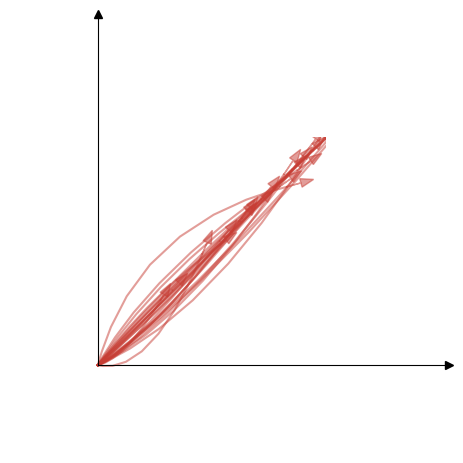

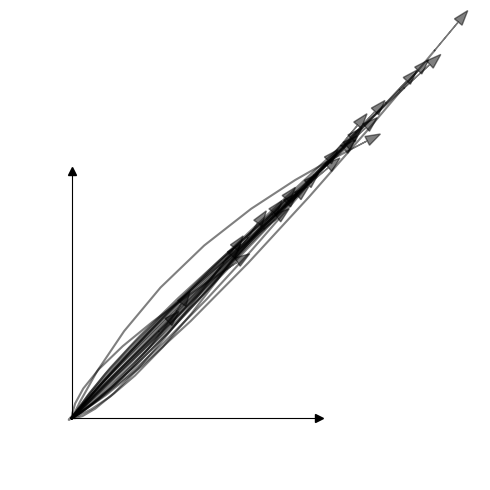

In [16]:
if rot_trajectories:

    data_file = data_files[0]
    
    dat = AM_loaded_data
    df1 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='PCA', loader_args=LD_args)
    df2 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='LQGCA', loader_args=LD_args)


    x = dat['spike_rates']
    xpca = x @ df1.iloc[0]['coef'][:, 0:jDIM]
    xdca = x @ df2.iloc[0]['coef']

    jpca1 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca1.fit(xpca)

    jpca2 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca2.fit(xdca)

    xpca_j = jpca1.transform(xpca)
    xdca_j = jpca2.transform(xdca)

    xpca_j_mean = np.mean(xpca_j, 0).squeeze()
    xdca_j_mean = np.mean(xdca_j, 0).squeeze()



    ################################### PLOT CODE ##############################

    # Save as two separate figures
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))
    ax = [ax1, ax2]

    for i in range(0, 25):
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xpca_j[0, t0:t1],  sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xpca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center and normalize trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[8, 1], trajectory[8, 0])

        # Rotate *clockwise* by theta
        R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[1].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.5)
        ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.08, color="k", alpha=0.5)
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xdca_j[0, t0:t1], sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xdca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[8, 1], trajectory[8, 0])

        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[0].plot(trajectory[:, 0], trajectory[:, 1], '#c73d34', alpha=0.5)
        ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.05, color="#c73d34", alpha=0.5)

    _, p = scipy.stats.wilcoxon(maxim[:, 0, 2], maxim[:, 1, 2], alternative='less')
    print('Re p:%f' % p)


    ax[0].set_aspect('equal')   
    ax[1].set_aspect('equal')
    ax[1].set_xlim([-0.5, 3.3])
    ax[1].set_ylim([-0.5, 3.3])

    ax[0].set_xlim([-0.5, 1.3])
    ax[0].set_ylim([-0.5, 1.3])


    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    ax[0].spines['left'].set_position('zero')
    ax[0].spines['bottom'].set_position('zero')
    ax[0].plot(2, 0, ">k", clip_on=False)
    ax[0].plot(0, 2, "^k", clip_on=False)
    ax[0].spines['left'].set_bounds(0, 2)
    ax[0].spines['bottom'].set_bounds(0, 2)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    ax[1].spines['left'].set_position('zero')
    ax[1].spines['bottom'].set_position('zero')
    ax[1].spines['left'].set_bounds(0, 2)
    ax[1].spines['bottom'].set_bounds(0, 2)
    ax[1].plot(2, 0, ">k", clip_on=False)
    ax[1].plot(0, 2, "^k", clip_on=False)

    fig1.tight_layout()
    #fig1.savefig('%s/trajectories_a.pdf' % figpath, bbox_inches='tight', pad_inches=0)

    fig2.tight_layout()
    #fig2.savefig('%s/trajectories_b.pdf' % figpath, bbox_inches='tight', pad_inches=0)


# Next Plots: Trajectory Amplification 

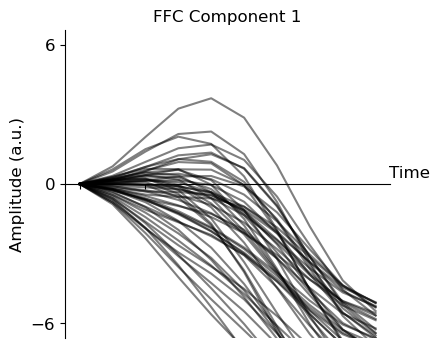

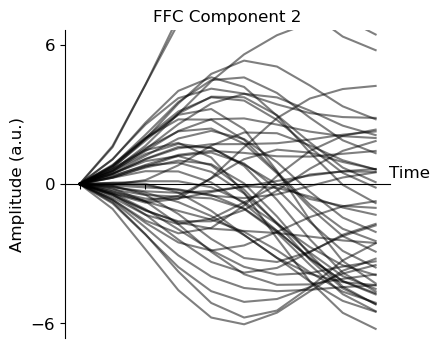

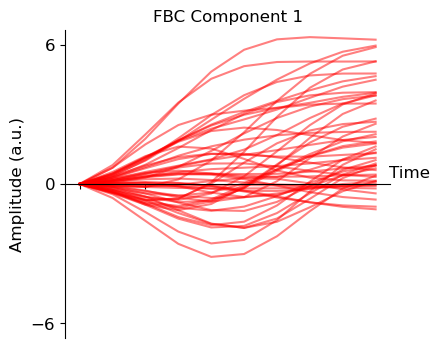

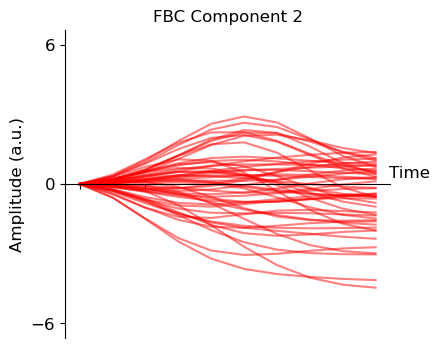

In [17]:
############## Trajectory Amplification #################
if run_dyn_range:

    dat = AM_loaded_data
    y = np.squeeze(dat['spike_rates'])

    colors = ['k', 'r']
    for j, dimreduc_method in enumerate(['PCA', 'LQGCA']):
        df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)

        #if dimreduc_method == 'LQGCA':
        #    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        if dimreduc_method == 'PCA':
            V = V[:, 0:DIM]        

        # Project data
        yproj = y @ V
        #yproj = np.array([yproj[t0:t0+40] for t0, t1 in dat['transition_times'] if t1 - t0 > 40])
        yproj = np.array([y_ - y_[0] for y_ in yproj])
        dY = np.concatenate(np.diff(yproj, axis=1), axis=0)
        Y_prestate = np.concatenate(yproj[:, :-1], axis=0)

        # Least squares
        A, _, _, _ = np.linalg.lstsq(Y_prestate, dY, rcond=None)
        _, s, _ = np.linalg.svd(A)
        #print('%s' % dimreduc_method + s)

        # Identify the directions in which there is the most amplification over multiple timesteps
        # Project the data along those directions and also record the amplification implied by the model
    
        # Iterate the lyapunov equation for 10 timesteps
        P = np.zeros((DIM, DIM))
        for _ in range(10):
            dP = A @ P + P @ A.T + np.eye(DIM)
            P += dP

        eig, U = np.linalg.eig(P)
        # eig, U = np.linalg.eig(scipy.linalg.expm(A.T) @ scipy.linalg.expm(A))
        eig = np.sort(eig)[::-1]
        U = U[:, np.argsort(eig)[::-1]]
        U = U[:, 0:2]
        # Plot smoothed, centered trajectories for all reaches in top 2 dimensions

        # Argsort by the maximum amplitude in the top 2 dimensions
        #trajectory = gaussian_filter1d(yproj, sigma=5, axis=1)
        trajectory = gaussian_filter1d(yproj, sigma=2, axis=1)

        trajectory -= trajectory[:, 0:1, :]
        trajectory = trajectory @ U
        dyn_range = np.max(np.abs(trajectory), axis=1)
        #dyn_range = np.max(np.abs(yproj @ U), axis=1)
        ordering = np.argsort(dyn_range, axis=0)[::-1]

        #t0 = trajectory[ordering[:, 0], :, 0]
        #t1 = trajectory[ordering[:, 1], :, 1]
        t0 = trajectory[:, :, 0]
        t1 = trajectory[:, :, 1]

        f1, a1 = plt.subplots(1, 1, figsize=(4.2, 4))
        f2, a2 = plt.subplots(1, 1, figsize=(4.2, 4))
        ax = [a1, a2]

        for i in range(min(50, t0.shape[0])):
            ax[0].plot(np.arange(len(t0[i])), t0[i], color=colors[j], alpha=0.5, linewidth=1.5)
            ax[1].plot(np.arange(len(t1[i])), t1[i], color=colors[j], alpha=0.5, linewidth=1.5)
            #ax[2*j].set_title(np.sum(eig))
            
        for a in ax:
            a.spines['bottom'].set_position('center')
            # Eliminate upper and right axes
            a.spines['right'].set_color('none')
            a.spines['top'].set_color('none')

            # Show ticks in the left and lower axes only
            a.xaxis.set_ticks_position('bottom')
            a.yaxis.set_ticks_position('left')

            a.set_xticks([0, 2])
            a.set_xticklabels([])
            a.tick_params(axis='both', labelsize=12)

            a.set_xlabel('Time (s)', fontsize=12)
            a.xaxis.set_label_coords(1.1, 0.56)
            
        # Set y scale according to the current yscale on PCA 0
        if j == 0:
            ylim_max = np.max(np.abs(t0[0])) + 1.5
            ylim = [-ylim_max, ylim_max]

        for a in ax:
            a.set_ylim(ylim)
            a.set_yticks([-int(ylim_max), 0, int(ylim_max)])
            a.set_ylabel('Amplitude (a.u.)', fontsize=12)

        if j == 0:
            ax[0].set_title('FFC Component 1', fontsize=12)
            ax[1].set_title('FFC Component 2', fontsize=12)
        else:
            ax[0].set_title('FBC Component 1', fontsize=12)
            ax[1].set_title('FBC Component 2', fontsize=12)

        #f1.tight_layout()
        #f2.tight_layout()
        #f1.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s1.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)
        #f2.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s2.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)


# Boxplots !

Im p:0.500000
0.5
0.5


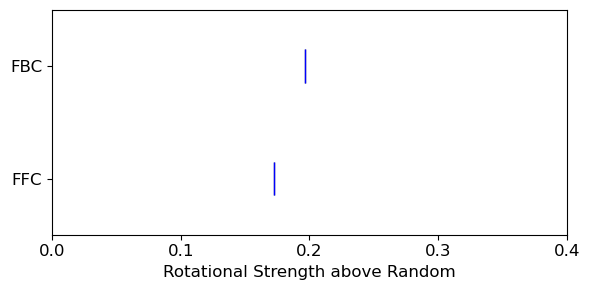

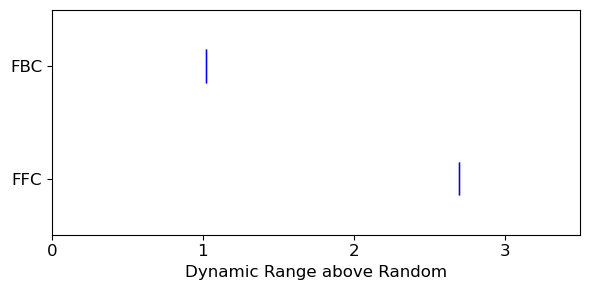

In [19]:
if boxplots:
    # Boxplots
    fig0, ax0 = plt.subplots(figsize=(6, 3))

    medianprops = dict(linewidth=1, color='b')
    whiskerprops=dict(linewidth=0)

    # Center relative to random - per recording session
    mu = np.mean(maxim_control[..., 1], axis=1)
    sigma = np.std(maxim_control[..., 1], axis=1)
    r1 = maxim[:, 0, 1] - mu
    r2 = maxim[:, 1, 1] - mu

    bplot = ax0.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)
    
    

    _, p = scipy.stats.wilcoxon(maxim[:, 0, 1], maxim[:, 1, 1], alternative='greater')
    print('Im p:%f' % p)

    # test that each is stochastically greater than the median random
    x1 = maxim[:, 0, 1] - np.median(maxim_control[..., 1].ravel())
    x2 = maxim[:, 1, 1] - np.median(maxim_control[..., 1].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')


    method1 = 'FBC'
    method2 = 'FFC'

    ax0.set_yticklabels([method1, method2], fontsize=12)
    ax0.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
    ax0.set_xlim([0, 0.4])
    ax0.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax0.set_xlabel('Rotational Strength above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax0.invert_yaxis()

    fig0.tight_layout()

    fig1, ax1 = plt.subplots(figsize=(6, 3))

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    whiskerprops = dict(linewidth=0)

    mu = np.mean(maxim_control[..., 2], axis=1)
    sigma = np.std(maxim_control[..., 2], axis=1)
    r1 = maxim[:, 0, 2] - mu
    r2 = maxim[:, 1, 2] - mu

    bplot = ax1.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)

    x1 = maxim[:, 0, 2] - np.median(maxim_control[..., 2].ravel())
    x2 = maxim[:, 1, 2] - np.median(maxim_control[..., 2].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')
    print(p1)
    print(p2)

    method1 = 'FBC'
    method2 = 'FFC'

    ax1.set_yticklabels([method1, method2], fontsize=12)
    ax1.set_xticks([0, 1, 2, 3, 4])
    ax1.set_xlim([0, 3.5])
    ax1.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax1.set_xlabel('Dynamic Range above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax1.invert_yaxis()

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)


    # ax.set_xlim([13, 0])

    fig1.tight_layout()
    #fig.savefig('%s/jpca_eig_bplot_wcontrol2.pdf' % figpath, pad_inches=1)

## Plots and Analyses for Region ML

In [33]:
calcs = True
rot_trajectories = True
run_dyn_range = True
boxplots = True

In [34]:
curr_Region = 'ML'
DIM = 21
jDIM = DIM - 1 # must be even for jPCA 
LD_args = {'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'region': curr_Region, 'degraded': True}
data_files = [df_dimreduc['data_file'][0]]
dpath = ML_data_file

### Generate random projections used to for later comparison

In [35]:
inner_reps = 1000
random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'

if not os.path.exists(random_proj_path):
    resultsd3 = []
    for i, data_file in tqdm(enumerate(data_files)):
       
        dat = ML_loaded_data
        y = np.squeeze(dat['spike_rates'])

        for j in tqdm(range(inner_reps)):
            V = scipy.stats.special_ortho_group.rvs(y.shape[-1], random_state=np.random.RandomState(j))
            V = V[:, 0:DIM]
            # Project data
            yproj = y @ V

            # Segment reaches into minimum length 30 timesteps reaches
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])
            # yproj = gaussian_filter1d(yproj, sigma=5)

            result_ = {}
            result_['data_file'] = data_file
            result_['inner_rep'] = j

            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            # ypred = yproj[:-1, :] @ jpca.M_skew
            #r2_linear = linmodel.score(yproj[:-1, :], np.diff(yproj, axis=0))
            result_['jeig'] = jpca.eigen_vals_

            yprojcent = np.array([y_ - y_[0:1, :] for y_ in yproj])
            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)
            resultsd3.append(result_)


            print(f"Done with jPCA fit {j+1} of {inner_reps}.")

    with open(random_proj_path, 'wb') as f:
        f.write(pickle.dumps(resultsd3))            

print('Loading Existing Random Control')

0it [00:00, ?it/s]

Done with jPCA fit 1 of 1000.


Done with jPCA fit 2 of 1000.


Done with jPCA fit 3 of 1000.


Done with jPCA fit 4 of 1000.


Done with jPCA fit 5 of 1000.


Done with jPCA fit 6 of 1000.


Done with jPCA fit 7 of 1000.


Done with jPCA fit 8 of 1000.


Done with jPCA fit 9 of 1000.


Done with jPCA fit 10 of 1000.


Done with jPCA fit 11 of 1000.


Done with jPCA fit 12 of 1000.


Done with jPCA fit 13 of 1000.


Done with jPCA fit 14 of 1000.


Done with jPCA fit 15 of 1000.


Done with jPCA fit 16 of 1000.


Done with jPCA fit 17 of 1000.


Done with jPCA fit 18 of 1000.


Done with jPCA fit 19 of 1000.


Done with jPCA fit 20 of 1000.


Done with jPCA fit 21 of 1000.


Done with jPCA fit 22 of 1000.


Done with jPCA fit 23 of 1000.


Done with jPCA fit 24 of 1000.


Done with jPCA fit 25 of 1000.


Done with jPCA fit 26 of 1000.


Done with jPCA fit 27 of 1000.


Done with jPCA fit 28 of 1000.


Done with jPCA fit 29 of 1000.


Done with jPCA fit 30 of 1000.


Done with jPCA fit 31 of 1000.


Done with jPCA fit 32 of 1000.


Done with jPCA fit 33 of 1000.


Done with jPCA fit 34 of 1000.


Done with jPCA fit 35 of 1000.


Done with jPCA fit 36 of 1000.


Done with jPCA fit 37 of 1000.


Done with jPCA fit 38 of 1000.


Done with jPCA fit 39 of 1000.


Done with jPCA fit 40 of 1000.


Done with jPCA fit 41 of 1000.


Done with jPCA fit 42 of 1000.


Done with jPCA fit 43 of 1000.


Done with jPCA fit 44 of 1000.


Done with jPCA fit 45 of 1000.


Done with jPCA fit 46 of 1000.


Done with jPCA fit 47 of 1000.


Done with jPCA fit 48 of 1000.


Done with jPCA fit 49 of 1000.


Done with jPCA fit 50 of 1000.


Done with jPCA fit 51 of 1000.


Done with jPCA fit 52 of 1000.


Done with jPCA fit 53 of 1000.


Done with jPCA fit 54 of 1000.


Done with jPCA fit 55 of 1000.


Done with jPCA fit 56 of 1000.


Done with jPCA fit 57 of 1000.


Done with jPCA fit 58 of 1000.


Done with jPCA fit 59 of 1000.


Done with jPCA fit 60 of 1000.


Done with jPCA fit 61 of 1000.


Done with jPCA fit 62 of 1000.


Done with jPCA fit 63 of 1000.


Done with jPCA fit 64 of 1000.


Done with jPCA fit 65 of 1000.


Done with jPCA fit 66 of 1000.


Done with jPCA fit 67 of 1000.


Done with jPCA fit 68 of 1000.


Done with jPCA fit 69 of 1000.


Done with jPCA fit 70 of 1000.


Done with jPCA fit 71 of 1000.


Done with jPCA fit 72 of 1000.


Done with jPCA fit 73 of 1000.


Done with jPCA fit 74 of 1000.


Done with jPCA fit 75 of 1000.


Done with jPCA fit 76 of 1000.


Done with jPCA fit 77 of 1000.


Done with jPCA fit 78 of 1000.


Done with jPCA fit 79 of 1000.


Done with jPCA fit 80 of 1000.


Done with jPCA fit 81 of 1000.


Done with jPCA fit 82 of 1000.


Done with jPCA fit 83 of 1000.


Done with jPCA fit 84 of 1000.


Done with jPCA fit 85 of 1000.


Done with jPCA fit 86 of 1000.


Done with jPCA fit 87 of 1000.


Done with jPCA fit 88 of 1000.


Done with jPCA fit 89 of 1000.


Done with jPCA fit 90 of 1000.


Done with jPCA fit 91 of 1000.


Done with jPCA fit 92 of 1000.


Done with jPCA fit 93 of 1000.


Done with jPCA fit 94 of 1000.


Done with jPCA fit 95 of 1000.


Done with jPCA fit 96 of 1000.


Done with jPCA fit 97 of 1000.


Done with jPCA fit 98 of 1000.


Done with jPCA fit 99 of 1000.


Done with jPCA fit 100 of 1000.


Done with jPCA fit 101 of 1000.


Done with jPCA fit 102 of 1000.


Done with jPCA fit 103 of 1000.


Done with jPCA fit 104 of 1000.


Done with jPCA fit 105 of 1000.


Done with jPCA fit 106 of 1000.


Done with jPCA fit 107 of 1000.


Done with jPCA fit 108 of 1000.


Done with jPCA fit 109 of 1000.


Done with jPCA fit 110 of 1000.


Done with jPCA fit 111 of 1000.


Done with jPCA fit 112 of 1000.


Done with jPCA fit 113 of 1000.


Done with jPCA fit 114 of 1000.


Done with jPCA fit 115 of 1000.


Done with jPCA fit 116 of 1000.


Done with jPCA fit 117 of 1000.


Done with jPCA fit 118 of 1000.


Done with jPCA fit 119 of 1000.


Done with jPCA fit 120 of 1000.


Done with jPCA fit 121 of 1000.


Done with jPCA fit 122 of 1000.


Done with jPCA fit 123 of 1000.


Done with jPCA fit 124 of 1000.


Done with jPCA fit 125 of 1000.


Done with jPCA fit 126 of 1000.


Done with jPCA fit 127 of 1000.


Done with jPCA fit 128 of 1000.


Done with jPCA fit 129 of 1000.


Done with jPCA fit 130 of 1000.


Done with jPCA fit 131 of 1000.


Done with jPCA fit 132 of 1000.


Done with jPCA fit 133 of 1000.


Done with jPCA fit 134 of 1000.


Done with jPCA fit 135 of 1000.


Done with jPCA fit 136 of 1000.


Done with jPCA fit 137 of 1000.


Done with jPCA fit 138 of 1000.


Done with jPCA fit 139 of 1000.


Done with jPCA fit 140 of 1000.


Done with jPCA fit 141 of 1000.


Done with jPCA fit 142 of 1000.


Done with jPCA fit 143 of 1000.


Done with jPCA fit 144 of 1000.


Done with jPCA fit 145 of 1000.


Done with jPCA fit 146 of 1000.


Done with jPCA fit 147 of 1000.


Done with jPCA fit 148 of 1000.


Done with jPCA fit 149 of 1000.


Done with jPCA fit 150 of 1000.


Done with jPCA fit 151 of 1000.


Done with jPCA fit 152 of 1000.


Done with jPCA fit 153 of 1000.


Done with jPCA fit 154 of 1000.


Done with jPCA fit 155 of 1000.


Done with jPCA fit 156 of 1000.


Done with jPCA fit 157 of 1000.


Done with jPCA fit 158 of 1000.


Done with jPCA fit 159 of 1000.


Done with jPCA fit 160 of 1000.


Done with jPCA fit 161 of 1000.


Done with jPCA fit 162 of 1000.


Done with jPCA fit 163 of 1000.


Done with jPCA fit 164 of 1000.


Done with jPCA fit 165 of 1000.


Done with jPCA fit 166 of 1000.


Done with jPCA fit 167 of 1000.


Done with jPCA fit 168 of 1000.


Done with jPCA fit 169 of 1000.


Done with jPCA fit 170 of 1000.


Done with jPCA fit 171 of 1000.


Done with jPCA fit 172 of 1000.


Done with jPCA fit 173 of 1000.


Done with jPCA fit 174 of 1000.


Done with jPCA fit 175 of 1000.


Done with jPCA fit 176 of 1000.


Done with jPCA fit 177 of 1000.


Done with jPCA fit 178 of 1000.


Done with jPCA fit 179 of 1000.


Done with jPCA fit 180 of 1000.


Done with jPCA fit 181 of 1000.


Done with jPCA fit 182 of 1000.


Done with jPCA fit 183 of 1000.


Done with jPCA fit 184 of 1000.


Done with jPCA fit 185 of 1000.


Done with jPCA fit 186 of 1000.


Done with jPCA fit 187 of 1000.


Done with jPCA fit 188 of 1000.


Done with jPCA fit 189 of 1000.


Done with jPCA fit 190 of 1000.


Done with jPCA fit 191 of 1000.


Done with jPCA fit 192 of 1000.


Done with jPCA fit 193 of 1000.


Done with jPCA fit 194 of 1000.


Done with jPCA fit 195 of 1000.


Done with jPCA fit 196 of 1000.


Done with jPCA fit 197 of 1000.


Done with jPCA fit 198 of 1000.


Done with jPCA fit 199 of 1000.


Done with jPCA fit 200 of 1000.


Done with jPCA fit 201 of 1000.


Done with jPCA fit 202 of 1000.


Done with jPCA fit 203 of 1000.


Done with jPCA fit 204 of 1000.


Done with jPCA fit 205 of 1000.


Done with jPCA fit 206 of 1000.


Done with jPCA fit 207 of 1000.


Done with jPCA fit 208 of 1000.


Done with jPCA fit 209 of 1000.


Done with jPCA fit 210 of 1000.


Done with jPCA fit 211 of 1000.


Done with jPCA fit 212 of 1000.


Done with jPCA fit 213 of 1000.


Done with jPCA fit 214 of 1000.


Done with jPCA fit 215 of 1000.


Done with jPCA fit 216 of 1000.


Done with jPCA fit 217 of 1000.


Done with jPCA fit 218 of 1000.


Done with jPCA fit 219 of 1000.


Done with jPCA fit 220 of 1000.


Done with jPCA fit 221 of 1000.


Done with jPCA fit 222 of 1000.


Done with jPCA fit 223 of 1000.


Done with jPCA fit 224 of 1000.


Done with jPCA fit 225 of 1000.


Done with jPCA fit 226 of 1000.


Done with jPCA fit 227 of 1000.


Done with jPCA fit 228 of 1000.


Done with jPCA fit 229 of 1000.


Done with jPCA fit 230 of 1000.


Done with jPCA fit 231 of 1000.


Done with jPCA fit 232 of 1000.


Done with jPCA fit 233 of 1000.


Done with jPCA fit 234 of 1000.


Done with jPCA fit 235 of 1000.


Done with jPCA fit 236 of 1000.


Done with jPCA fit 237 of 1000.


Done with jPCA fit 238 of 1000.


Done with jPCA fit 239 of 1000.


Done with jPCA fit 240 of 1000.


Done with jPCA fit 241 of 1000.


Done with jPCA fit 242 of 1000.


Done with jPCA fit 243 of 1000.


Done with jPCA fit 244 of 1000.


Done with jPCA fit 245 of 1000.


Done with jPCA fit 246 of 1000.


Done with jPCA fit 247 of 1000.


Done with jPCA fit 248 of 1000.


Done with jPCA fit 249 of 1000.


Done with jPCA fit 250 of 1000.


Done with jPCA fit 251 of 1000.


Done with jPCA fit 252 of 1000.


Done with jPCA fit 253 of 1000.


Done with jPCA fit 254 of 1000.


Done with jPCA fit 255 of 1000.


Done with jPCA fit 256 of 1000.


Done with jPCA fit 257 of 1000.


Done with jPCA fit 258 of 1000.


Done with jPCA fit 259 of 1000.


Done with jPCA fit 260 of 1000.


Done with jPCA fit 261 of 1000.


Done with jPCA fit 262 of 1000.


Done with jPCA fit 263 of 1000.


Done with jPCA fit 264 of 1000.


Done with jPCA fit 265 of 1000.


Done with jPCA fit 266 of 1000.


Done with jPCA fit 267 of 1000.


Done with jPCA fit 268 of 1000.


Done with jPCA fit 269 of 1000.


Done with jPCA fit 270 of 1000.


Done with jPCA fit 271 of 1000.


Done with jPCA fit 272 of 1000.


Done with jPCA fit 273 of 1000.


Done with jPCA fit 274 of 1000.


Done with jPCA fit 275 of 1000.


Done with jPCA fit 276 of 1000.


Done with jPCA fit 277 of 1000.


Done with jPCA fit 278 of 1000.


Done with jPCA fit 279 of 1000.


Done with jPCA fit 280 of 1000.


Done with jPCA fit 281 of 1000.


Done with jPCA fit 282 of 1000.


Done with jPCA fit 283 of 1000.


Done with jPCA fit 284 of 1000.


Done with jPCA fit 285 of 1000.


Done with jPCA fit 286 of 1000.


Done with jPCA fit 287 of 1000.


Done with jPCA fit 288 of 1000.


Done with jPCA fit 289 of 1000.


Done with jPCA fit 290 of 1000.


Done with jPCA fit 291 of 1000.


Done with jPCA fit 292 of 1000.


Done with jPCA fit 293 of 1000.


Done with jPCA fit 294 of 1000.


Done with jPCA fit 295 of 1000.


Done with jPCA fit 296 of 1000.


Done with jPCA fit 297 of 1000.


Done with jPCA fit 298 of 1000.


Done with jPCA fit 299 of 1000.


Done with jPCA fit 300 of 1000.


Done with jPCA fit 301 of 1000.


Done with jPCA fit 302 of 1000.


Done with jPCA fit 303 of 1000.


Done with jPCA fit 304 of 1000.


Done with jPCA fit 305 of 1000.


Done with jPCA fit 306 of 1000.


Done with jPCA fit 307 of 1000.


Done with jPCA fit 308 of 1000.


Done with jPCA fit 309 of 1000.


Done with jPCA fit 310 of 1000.


Done with jPCA fit 311 of 1000.


Done with jPCA fit 312 of 1000.


Done with jPCA fit 313 of 1000.


Done with jPCA fit 314 of 1000.


Done with jPCA fit 315 of 1000.


Done with jPCA fit 316 of 1000.


Done with jPCA fit 317 of 1000.


Done with jPCA fit 318 of 1000.


Done with jPCA fit 319 of 1000.


Done with jPCA fit 320 of 1000.


Done with jPCA fit 321 of 1000.


Done with jPCA fit 322 of 1000.


Done with jPCA fit 323 of 1000.


Done with jPCA fit 324 of 1000.


Done with jPCA fit 325 of 1000.


Done with jPCA fit 326 of 1000.


Done with jPCA fit 327 of 1000.


Done with jPCA fit 328 of 1000.


Done with jPCA fit 329 of 1000.


Done with jPCA fit 330 of 1000.


Done with jPCA fit 331 of 1000.


Done with jPCA fit 332 of 1000.


Done with jPCA fit 333 of 1000.


Done with jPCA fit 334 of 1000.


Done with jPCA fit 335 of 1000.


Done with jPCA fit 336 of 1000.


Done with jPCA fit 337 of 1000.


Done with jPCA fit 338 of 1000.


Done with jPCA fit 339 of 1000.


Done with jPCA fit 340 of 1000.


Done with jPCA fit 341 of 1000.


Done with jPCA fit 342 of 1000.


Done with jPCA fit 343 of 1000.


Done with jPCA fit 344 of 1000.


Done with jPCA fit 345 of 1000.


Done with jPCA fit 346 of 1000.


Done with jPCA fit 347 of 1000.


Done with jPCA fit 348 of 1000.


Done with jPCA fit 349 of 1000.


Done with jPCA fit 350 of 1000.


Done with jPCA fit 351 of 1000.


Done with jPCA fit 352 of 1000.


Done with jPCA fit 353 of 1000.


Done with jPCA fit 354 of 1000.


Done with jPCA fit 355 of 1000.


Done with jPCA fit 356 of 1000.


Done with jPCA fit 357 of 1000.


Done with jPCA fit 358 of 1000.


Done with jPCA fit 359 of 1000.


Done with jPCA fit 360 of 1000.


Done with jPCA fit 361 of 1000.


Done with jPCA fit 362 of 1000.


Done with jPCA fit 363 of 1000.


Done with jPCA fit 364 of 1000.


Done with jPCA fit 365 of 1000.


Done with jPCA fit 366 of 1000.


Done with jPCA fit 367 of 1000.


Done with jPCA fit 368 of 1000.


Done with jPCA fit 369 of 1000.


Done with jPCA fit 370 of 1000.


Done with jPCA fit 371 of 1000.


Done with jPCA fit 372 of 1000.


Done with jPCA fit 373 of 1000.


Done with jPCA fit 374 of 1000.


Done with jPCA fit 375 of 1000.


Done with jPCA fit 376 of 1000.


Done with jPCA fit 377 of 1000.


Done with jPCA fit 378 of 1000.


Done with jPCA fit 379 of 1000.


Done with jPCA fit 380 of 1000.


Done with jPCA fit 381 of 1000.


Done with jPCA fit 382 of 1000.


Done with jPCA fit 383 of 1000.


Done with jPCA fit 384 of 1000.


Done with jPCA fit 385 of 1000.


Done with jPCA fit 386 of 1000.


Done with jPCA fit 387 of 1000.


Done with jPCA fit 388 of 1000.


Done with jPCA fit 389 of 1000.


Done with jPCA fit 390 of 1000.


Done with jPCA fit 391 of 1000.


Done with jPCA fit 392 of 1000.


Done with jPCA fit 393 of 1000.


Done with jPCA fit 394 of 1000.


Done with jPCA fit 395 of 1000.


Done with jPCA fit 396 of 1000.


Done with jPCA fit 397 of 1000.


Done with jPCA fit 398 of 1000.


Done with jPCA fit 399 of 1000.


Done with jPCA fit 400 of 1000.


Done with jPCA fit 401 of 1000.


Done with jPCA fit 402 of 1000.


Done with jPCA fit 403 of 1000.


Done with jPCA fit 404 of 1000.


Done with jPCA fit 405 of 1000.


Done with jPCA fit 406 of 1000.


Done with jPCA fit 407 of 1000.


Done with jPCA fit 408 of 1000.


Done with jPCA fit 409 of 1000.


Done with jPCA fit 410 of 1000.


Done with jPCA fit 411 of 1000.


Done with jPCA fit 412 of 1000.


Done with jPCA fit 413 of 1000.


Done with jPCA fit 414 of 1000.


Done with jPCA fit 415 of 1000.


Done with jPCA fit 416 of 1000.


Done with jPCA fit 417 of 1000.


Done with jPCA fit 418 of 1000.


Done with jPCA fit 419 of 1000.


Done with jPCA fit 420 of 1000.


Done with jPCA fit 421 of 1000.


Done with jPCA fit 422 of 1000.


Done with jPCA fit 423 of 1000.


Done with jPCA fit 424 of 1000.


Done with jPCA fit 425 of 1000.


Done with jPCA fit 426 of 1000.


Done with jPCA fit 427 of 1000.


Done with jPCA fit 428 of 1000.


Done with jPCA fit 429 of 1000.


Done with jPCA fit 430 of 1000.


Done with jPCA fit 431 of 1000.


Done with jPCA fit 432 of 1000.


Done with jPCA fit 433 of 1000.


Done with jPCA fit 434 of 1000.


Done with jPCA fit 435 of 1000.


Done with jPCA fit 436 of 1000.


Done with jPCA fit 437 of 1000.


Done with jPCA fit 438 of 1000.


Done with jPCA fit 439 of 1000.


Done with jPCA fit 440 of 1000.


Done with jPCA fit 441 of 1000.


Done with jPCA fit 442 of 1000.


Done with jPCA fit 443 of 1000.


Done with jPCA fit 444 of 1000.


Done with jPCA fit 445 of 1000.


Done with jPCA fit 446 of 1000.


Done with jPCA fit 447 of 1000.


Done with jPCA fit 448 of 1000.


Done with jPCA fit 449 of 1000.


Done with jPCA fit 450 of 1000.


Done with jPCA fit 451 of 1000.


Done with jPCA fit 452 of 1000.


Done with jPCA fit 453 of 1000.


Done with jPCA fit 454 of 1000.


Done with jPCA fit 455 of 1000.


Done with jPCA fit 456 of 1000.


Done with jPCA fit 457 of 1000.


Done with jPCA fit 458 of 1000.


Done with jPCA fit 459 of 1000.


Done with jPCA fit 460 of 1000.


Done with jPCA fit 461 of 1000.


Done with jPCA fit 462 of 1000.


Done with jPCA fit 463 of 1000.


Done with jPCA fit 464 of 1000.


Done with jPCA fit 465 of 1000.


Done with jPCA fit 466 of 1000.


Done with jPCA fit 467 of 1000.


Done with jPCA fit 468 of 1000.


Done with jPCA fit 469 of 1000.


Done with jPCA fit 470 of 1000.


Done with jPCA fit 471 of 1000.


Done with jPCA fit 472 of 1000.


Done with jPCA fit 473 of 1000.


Done with jPCA fit 474 of 1000.


Done with jPCA fit 475 of 1000.


Done with jPCA fit 476 of 1000.


Done with jPCA fit 477 of 1000.


Done with jPCA fit 478 of 1000.


Done with jPCA fit 479 of 1000.


Done with jPCA fit 480 of 1000.


Done with jPCA fit 481 of 1000.


Done with jPCA fit 482 of 1000.


Done with jPCA fit 483 of 1000.


Done with jPCA fit 484 of 1000.


Done with jPCA fit 485 of 1000.


Done with jPCA fit 486 of 1000.


Done with jPCA fit 487 of 1000.


Done with jPCA fit 488 of 1000.


Done with jPCA fit 489 of 1000.


Done with jPCA fit 490 of 1000.


Done with jPCA fit 491 of 1000.


Done with jPCA fit 492 of 1000.


Done with jPCA fit 493 of 1000.


Done with jPCA fit 494 of 1000.


Done with jPCA fit 495 of 1000.


Done with jPCA fit 496 of 1000.


Done with jPCA fit 497 of 1000.


Done with jPCA fit 498 of 1000.


Done with jPCA fit 499 of 1000.


Done with jPCA fit 500 of 1000.


Done with jPCA fit 501 of 1000.


Done with jPCA fit 502 of 1000.


Done with jPCA fit 503 of 1000.


Done with jPCA fit 504 of 1000.


Done with jPCA fit 505 of 1000.


Done with jPCA fit 506 of 1000.


Done with jPCA fit 507 of 1000.


Done with jPCA fit 508 of 1000.


Done with jPCA fit 509 of 1000.


Done with jPCA fit 510 of 1000.


Done with jPCA fit 511 of 1000.


Done with jPCA fit 512 of 1000.


Done with jPCA fit 513 of 1000.


Done with jPCA fit 514 of 1000.


Done with jPCA fit 515 of 1000.


Done with jPCA fit 516 of 1000.


Done with jPCA fit 517 of 1000.


Done with jPCA fit 518 of 1000.


Done with jPCA fit 519 of 1000.


Done with jPCA fit 520 of 1000.


Done with jPCA fit 521 of 1000.


Done with jPCA fit 522 of 1000.


Done with jPCA fit 523 of 1000.


Done with jPCA fit 524 of 1000.


Done with jPCA fit 525 of 1000.


Done with jPCA fit 526 of 1000.


Done with jPCA fit 527 of 1000.


Done with jPCA fit 528 of 1000.


Done with jPCA fit 529 of 1000.


Done with jPCA fit 530 of 1000.


Done with jPCA fit 531 of 1000.


Done with jPCA fit 532 of 1000.


Done with jPCA fit 533 of 1000.


Done with jPCA fit 534 of 1000.


Done with jPCA fit 535 of 1000.


Done with jPCA fit 536 of 1000.


Done with jPCA fit 537 of 1000.


Done with jPCA fit 538 of 1000.


Done with jPCA fit 539 of 1000.


Done with jPCA fit 540 of 1000.


Done with jPCA fit 541 of 1000.


Done with jPCA fit 542 of 1000.


Done with jPCA fit 543 of 1000.


Done with jPCA fit 544 of 1000.


Done with jPCA fit 545 of 1000.


Done with jPCA fit 546 of 1000.


Done with jPCA fit 547 of 1000.


Done with jPCA fit 548 of 1000.


Done with jPCA fit 549 of 1000.


Done with jPCA fit 550 of 1000.


Done with jPCA fit 551 of 1000.


Done with jPCA fit 552 of 1000.


Done with jPCA fit 553 of 1000.


Done with jPCA fit 554 of 1000.


Done with jPCA fit 555 of 1000.


Done with jPCA fit 556 of 1000.


Done with jPCA fit 557 of 1000.


Done with jPCA fit 558 of 1000.


Done with jPCA fit 559 of 1000.


Done with jPCA fit 560 of 1000.


Done with jPCA fit 561 of 1000.


Done with jPCA fit 562 of 1000.


Done with jPCA fit 563 of 1000.


Done with jPCA fit 564 of 1000.


Done with jPCA fit 565 of 1000.


Done with jPCA fit 566 of 1000.


Done with jPCA fit 567 of 1000.


Done with jPCA fit 568 of 1000.


Done with jPCA fit 569 of 1000.


Done with jPCA fit 570 of 1000.


Done with jPCA fit 571 of 1000.


Done with jPCA fit 572 of 1000.


Done with jPCA fit 573 of 1000.


Done with jPCA fit 574 of 1000.


Done with jPCA fit 575 of 1000.


Done with jPCA fit 576 of 1000.


Done with jPCA fit 577 of 1000.


Done with jPCA fit 578 of 1000.


Done with jPCA fit 579 of 1000.


Done with jPCA fit 580 of 1000.


Done with jPCA fit 581 of 1000.


Done with jPCA fit 582 of 1000.


Done with jPCA fit 583 of 1000.


Done with jPCA fit 584 of 1000.


Done with jPCA fit 585 of 1000.


Done with jPCA fit 586 of 1000.


Done with jPCA fit 587 of 1000.


Done with jPCA fit 588 of 1000.


Done with jPCA fit 589 of 1000.


Done with jPCA fit 590 of 1000.


Done with jPCA fit 591 of 1000.


Done with jPCA fit 592 of 1000.


Done with jPCA fit 593 of 1000.


Done with jPCA fit 594 of 1000.


Done with jPCA fit 595 of 1000.


Done with jPCA fit 596 of 1000.


Done with jPCA fit 597 of 1000.


Done with jPCA fit 598 of 1000.


Done with jPCA fit 599 of 1000.


Done with jPCA fit 600 of 1000.


Done with jPCA fit 601 of 1000.


Done with jPCA fit 602 of 1000.


Done with jPCA fit 603 of 1000.


Done with jPCA fit 604 of 1000.


Done with jPCA fit 605 of 1000.


Done with jPCA fit 606 of 1000.


Done with jPCA fit 607 of 1000.


Done with jPCA fit 608 of 1000.


Done with jPCA fit 609 of 1000.


Done with jPCA fit 610 of 1000.


Done with jPCA fit 611 of 1000.


Done with jPCA fit 612 of 1000.


Done with jPCA fit 613 of 1000.


Done with jPCA fit 614 of 1000.


Done with jPCA fit 615 of 1000.


Done with jPCA fit 616 of 1000.


Done with jPCA fit 617 of 1000.


Done with jPCA fit 618 of 1000.


Done with jPCA fit 619 of 1000.


Done with jPCA fit 620 of 1000.


Done with jPCA fit 621 of 1000.


Done with jPCA fit 622 of 1000.


Done with jPCA fit 623 of 1000.


Done with jPCA fit 624 of 1000.


Done with jPCA fit 625 of 1000.


Done with jPCA fit 626 of 1000.


Done with jPCA fit 627 of 1000.


Done with jPCA fit 628 of 1000.


Done with jPCA fit 629 of 1000.


Done with jPCA fit 630 of 1000.


Done with jPCA fit 631 of 1000.


Done with jPCA fit 632 of 1000.


Done with jPCA fit 633 of 1000.


Done with jPCA fit 634 of 1000.


Done with jPCA fit 635 of 1000.


Done with jPCA fit 636 of 1000.


Done with jPCA fit 637 of 1000.


Done with jPCA fit 638 of 1000.


Done with jPCA fit 639 of 1000.


Done with jPCA fit 640 of 1000.


Done with jPCA fit 641 of 1000.


Done with jPCA fit 642 of 1000.


Done with jPCA fit 643 of 1000.


Done with jPCA fit 644 of 1000.


Done with jPCA fit 645 of 1000.


Done with jPCA fit 646 of 1000.


Done with jPCA fit 647 of 1000.


Done with jPCA fit 648 of 1000.


Done with jPCA fit 649 of 1000.


Done with jPCA fit 650 of 1000.


Done with jPCA fit 651 of 1000.


Done with jPCA fit 652 of 1000.


Done with jPCA fit 653 of 1000.


Done with jPCA fit 654 of 1000.


Done with jPCA fit 655 of 1000.


Done with jPCA fit 656 of 1000.


Done with jPCA fit 657 of 1000.


Done with jPCA fit 658 of 1000.


Done with jPCA fit 659 of 1000.


Done with jPCA fit 660 of 1000.


Done with jPCA fit 661 of 1000.


Done with jPCA fit 662 of 1000.


Done with jPCA fit 663 of 1000.


Done with jPCA fit 664 of 1000.


Done with jPCA fit 665 of 1000.


Done with jPCA fit 666 of 1000.


Done with jPCA fit 667 of 1000.


Done with jPCA fit 668 of 1000.


Done with jPCA fit 669 of 1000.


Done with jPCA fit 670 of 1000.


Done with jPCA fit 671 of 1000.


Done with jPCA fit 672 of 1000.


Done with jPCA fit 673 of 1000.


Done with jPCA fit 674 of 1000.


Done with jPCA fit 675 of 1000.


Done with jPCA fit 676 of 1000.


Done with jPCA fit 677 of 1000.


Done with jPCA fit 678 of 1000.


Done with jPCA fit 679 of 1000.


Done with jPCA fit 680 of 1000.


Done with jPCA fit 681 of 1000.


Done with jPCA fit 682 of 1000.


Done with jPCA fit 683 of 1000.


Done with jPCA fit 684 of 1000.


Done with jPCA fit 685 of 1000.


Done with jPCA fit 686 of 1000.


Done with jPCA fit 687 of 1000.


Done with jPCA fit 688 of 1000.


Done with jPCA fit 689 of 1000.


Done with jPCA fit 690 of 1000.


Done with jPCA fit 691 of 1000.


Done with jPCA fit 692 of 1000.


Done with jPCA fit 693 of 1000.


Done with jPCA fit 694 of 1000.


Done with jPCA fit 695 of 1000.


Done with jPCA fit 696 of 1000.


Done with jPCA fit 697 of 1000.


Done with jPCA fit 698 of 1000.


Done with jPCA fit 699 of 1000.


Done with jPCA fit 700 of 1000.


Done with jPCA fit 701 of 1000.


Done with jPCA fit 702 of 1000.


Done with jPCA fit 703 of 1000.


Done with jPCA fit 704 of 1000.


Done with jPCA fit 705 of 1000.


Done with jPCA fit 706 of 1000.


Done with jPCA fit 707 of 1000.


Done with jPCA fit 708 of 1000.


Done with jPCA fit 709 of 1000.


Done with jPCA fit 710 of 1000.


Done with jPCA fit 711 of 1000.


Done with jPCA fit 712 of 1000.


Done with jPCA fit 713 of 1000.


Done with jPCA fit 714 of 1000.


Done with jPCA fit 715 of 1000.


Done with jPCA fit 716 of 1000.


Done with jPCA fit 717 of 1000.


Done with jPCA fit 718 of 1000.


Done with jPCA fit 719 of 1000.


Done with jPCA fit 720 of 1000.


Done with jPCA fit 721 of 1000.


Done with jPCA fit 722 of 1000.


Done with jPCA fit 723 of 1000.


Done with jPCA fit 724 of 1000.


Done with jPCA fit 725 of 1000.


Done with jPCA fit 726 of 1000.


Done with jPCA fit 727 of 1000.


Done with jPCA fit 728 of 1000.


Done with jPCA fit 729 of 1000.


Done with jPCA fit 730 of 1000.


Done with jPCA fit 731 of 1000.


Done with jPCA fit 732 of 1000.


Done with jPCA fit 733 of 1000.


Done with jPCA fit 734 of 1000.


Done with jPCA fit 735 of 1000.


Done with jPCA fit 736 of 1000.


Done with jPCA fit 737 of 1000.


Done with jPCA fit 738 of 1000.


Done with jPCA fit 739 of 1000.


Done with jPCA fit 740 of 1000.


Done with jPCA fit 741 of 1000.


Done with jPCA fit 742 of 1000.


Done with jPCA fit 743 of 1000.


Done with jPCA fit 744 of 1000.


Done with jPCA fit 745 of 1000.


Done with jPCA fit 746 of 1000.


Done with jPCA fit 747 of 1000.


Done with jPCA fit 748 of 1000.


Done with jPCA fit 749 of 1000.


Done with jPCA fit 750 of 1000.


Done with jPCA fit 751 of 1000.


Done with jPCA fit 752 of 1000.


Done with jPCA fit 753 of 1000.


Done with jPCA fit 754 of 1000.


Done with jPCA fit 755 of 1000.


Done with jPCA fit 756 of 1000.


Done with jPCA fit 757 of 1000.


Done with jPCA fit 758 of 1000.


Done with jPCA fit 759 of 1000.


Done with jPCA fit 760 of 1000.


Done with jPCA fit 761 of 1000.


Done with jPCA fit 762 of 1000.


Done with jPCA fit 763 of 1000.


Done with jPCA fit 764 of 1000.


Done with jPCA fit 765 of 1000.


Done with jPCA fit 766 of 1000.


Done with jPCA fit 767 of 1000.


Done with jPCA fit 768 of 1000.


Done with jPCA fit 769 of 1000.


Done with jPCA fit 770 of 1000.


Done with jPCA fit 771 of 1000.


Done with jPCA fit 772 of 1000.


Done with jPCA fit 773 of 1000.


Done with jPCA fit 774 of 1000.


Done with jPCA fit 775 of 1000.


Done with jPCA fit 776 of 1000.


Done with jPCA fit 777 of 1000.


Done with jPCA fit 778 of 1000.


Done with jPCA fit 779 of 1000.


Done with jPCA fit 780 of 1000.


Done with jPCA fit 781 of 1000.


Done with jPCA fit 782 of 1000.


Done with jPCA fit 783 of 1000.


Done with jPCA fit 784 of 1000.


Done with jPCA fit 785 of 1000.


Done with jPCA fit 786 of 1000.


Done with jPCA fit 787 of 1000.


Done with jPCA fit 788 of 1000.


Done with jPCA fit 789 of 1000.


Done with jPCA fit 790 of 1000.


Done with jPCA fit 791 of 1000.


Done with jPCA fit 792 of 1000.


Done with jPCA fit 793 of 1000.


Done with jPCA fit 794 of 1000.


Done with jPCA fit 795 of 1000.


Done with jPCA fit 796 of 1000.


Done with jPCA fit 797 of 1000.


Done with jPCA fit 798 of 1000.


Done with jPCA fit 799 of 1000.


Done with jPCA fit 800 of 1000.


Done with jPCA fit 801 of 1000.


Done with jPCA fit 802 of 1000.


Done with jPCA fit 803 of 1000.


Done with jPCA fit 804 of 1000.


Done with jPCA fit 805 of 1000.


Done with jPCA fit 806 of 1000.


Done with jPCA fit 807 of 1000.


Done with jPCA fit 808 of 1000.


Done with jPCA fit 809 of 1000.


Done with jPCA fit 810 of 1000.


Done with jPCA fit 811 of 1000.


Done with jPCA fit 812 of 1000.


Done with jPCA fit 813 of 1000.


Done with jPCA fit 814 of 1000.


Done with jPCA fit 815 of 1000.


Done with jPCA fit 816 of 1000.


Done with jPCA fit 817 of 1000.


Done with jPCA fit 818 of 1000.


Done with jPCA fit 819 of 1000.


Done with jPCA fit 820 of 1000.


Done with jPCA fit 821 of 1000.


Done with jPCA fit 822 of 1000.


Done with jPCA fit 823 of 1000.


Done with jPCA fit 824 of 1000.


Done with jPCA fit 825 of 1000.


Done with jPCA fit 826 of 1000.


Done with jPCA fit 827 of 1000.


Done with jPCA fit 828 of 1000.


Done with jPCA fit 829 of 1000.


Done with jPCA fit 830 of 1000.


Done with jPCA fit 831 of 1000.


Done with jPCA fit 832 of 1000.


Done with jPCA fit 833 of 1000.


Done with jPCA fit 834 of 1000.


Done with jPCA fit 835 of 1000.


Done with jPCA fit 836 of 1000.


Done with jPCA fit 837 of 1000.


Done with jPCA fit 838 of 1000.


Done with jPCA fit 839 of 1000.


Done with jPCA fit 840 of 1000.


Done with jPCA fit 841 of 1000.


Done with jPCA fit 842 of 1000.


Done with jPCA fit 843 of 1000.


Done with jPCA fit 844 of 1000.


Done with jPCA fit 845 of 1000.


Done with jPCA fit 846 of 1000.


Done with jPCA fit 847 of 1000.


Done with jPCA fit 848 of 1000.


Done with jPCA fit 849 of 1000.


Done with jPCA fit 850 of 1000.


Done with jPCA fit 851 of 1000.


Done with jPCA fit 852 of 1000.


Done with jPCA fit 853 of 1000.


Done with jPCA fit 854 of 1000.


Done with jPCA fit 855 of 1000.


Done with jPCA fit 856 of 1000.


Done with jPCA fit 857 of 1000.


Done with jPCA fit 858 of 1000.


Done with jPCA fit 859 of 1000.


Done with jPCA fit 860 of 1000.


Done with jPCA fit 861 of 1000.


Done with jPCA fit 862 of 1000.


Done with jPCA fit 863 of 1000.


Done with jPCA fit 864 of 1000.


Done with jPCA fit 865 of 1000.


Done with jPCA fit 866 of 1000.


Done with jPCA fit 867 of 1000.


Done with jPCA fit 868 of 1000.


Done with jPCA fit 869 of 1000.


Done with jPCA fit 870 of 1000.


Done with jPCA fit 871 of 1000.


Done with jPCA fit 872 of 1000.


Done with jPCA fit 873 of 1000.


Done with jPCA fit 874 of 1000.


Done with jPCA fit 875 of 1000.


Done with jPCA fit 876 of 1000.


Done with jPCA fit 877 of 1000.


Done with jPCA fit 878 of 1000.


Done with jPCA fit 879 of 1000.


Done with jPCA fit 880 of 1000.


Done with jPCA fit 881 of 1000.


Done with jPCA fit 882 of 1000.


Done with jPCA fit 883 of 1000.


Done with jPCA fit 884 of 1000.


Done with jPCA fit 885 of 1000.


Done with jPCA fit 886 of 1000.


Done with jPCA fit 887 of 1000.


Done with jPCA fit 888 of 1000.


Done with jPCA fit 889 of 1000.


Done with jPCA fit 890 of 1000.


Done with jPCA fit 891 of 1000.


Done with jPCA fit 892 of 1000.


Done with jPCA fit 893 of 1000.


Done with jPCA fit 894 of 1000.


Done with jPCA fit 895 of 1000.


Done with jPCA fit 896 of 1000.


Done with jPCA fit 897 of 1000.


Done with jPCA fit 898 of 1000.


Done with jPCA fit 899 of 1000.


Done with jPCA fit 900 of 1000.


Done with jPCA fit 901 of 1000.


Done with jPCA fit 902 of 1000.


Done with jPCA fit 903 of 1000.


Done with jPCA fit 904 of 1000.


Done with jPCA fit 905 of 1000.


Done with jPCA fit 906 of 1000.


Done with jPCA fit 907 of 1000.


Done with jPCA fit 908 of 1000.


Done with jPCA fit 909 of 1000.


Done with jPCA fit 910 of 1000.


Done with jPCA fit 911 of 1000.


Done with jPCA fit 912 of 1000.


Done with jPCA fit 913 of 1000.


Done with jPCA fit 914 of 1000.


Done with jPCA fit 915 of 1000.


Done with jPCA fit 916 of 1000.


Done with jPCA fit 917 of 1000.


Done with jPCA fit 918 of 1000.


Done with jPCA fit 919 of 1000.


Done with jPCA fit 920 of 1000.


Done with jPCA fit 921 of 1000.


Done with jPCA fit 922 of 1000.


Done with jPCA fit 923 of 1000.


Done with jPCA fit 924 of 1000.


Done with jPCA fit 925 of 1000.


Done with jPCA fit 926 of 1000.


Done with jPCA fit 927 of 1000.


Done with jPCA fit 928 of 1000.


Done with jPCA fit 929 of 1000.


Done with jPCA fit 930 of 1000.


Done with jPCA fit 931 of 1000.


Done with jPCA fit 932 of 1000.


Done with jPCA fit 933 of 1000.


Done with jPCA fit 934 of 1000.


Done with jPCA fit 935 of 1000.


Done with jPCA fit 936 of 1000.


Done with jPCA fit 937 of 1000.


Done with jPCA fit 938 of 1000.


Done with jPCA fit 939 of 1000.


Done with jPCA fit 940 of 1000.


Done with jPCA fit 941 of 1000.


Done with jPCA fit 942 of 1000.


Done with jPCA fit 943 of 1000.


Done with jPCA fit 944 of 1000.


Done with jPCA fit 945 of 1000.


Done with jPCA fit 946 of 1000.


Done with jPCA fit 947 of 1000.


Done with jPCA fit 948 of 1000.


Done with jPCA fit 949 of 1000.


Done with jPCA fit 950 of 1000.


Done with jPCA fit 951 of 1000.


Done with jPCA fit 952 of 1000.


Done with jPCA fit 953 of 1000.


Done with jPCA fit 954 of 1000.


Done with jPCA fit 955 of 1000.


Done with jPCA fit 956 of 1000.


Done with jPCA fit 957 of 1000.


Done with jPCA fit 958 of 1000.


Done with jPCA fit 959 of 1000.


Done with jPCA fit 960 of 1000.


Done with jPCA fit 961 of 1000.


Done with jPCA fit 962 of 1000.


Done with jPCA fit 963 of 1000.


Done with jPCA fit 964 of 1000.


Done with jPCA fit 965 of 1000.


Done with jPCA fit 966 of 1000.


Done with jPCA fit 967 of 1000.


Done with jPCA fit 968 of 1000.


Done with jPCA fit 969 of 1000.


Done with jPCA fit 970 of 1000.


Done with jPCA fit 971 of 1000.


Done with jPCA fit 972 of 1000.


Done with jPCA fit 973 of 1000.


Done with jPCA fit 974 of 1000.


Done with jPCA fit 975 of 1000.


Done with jPCA fit 976 of 1000.


Done with jPCA fit 977 of 1000.


Done with jPCA fit 978 of 1000.


Done with jPCA fit 979 of 1000.


Done with jPCA fit 980 of 1000.


Done with jPCA fit 981 of 1000.


Done with jPCA fit 982 of 1000.


Done with jPCA fit 983 of 1000.


Done with jPCA fit 984 of 1000.


Done with jPCA fit 985 of 1000.


Done with jPCA fit 986 of 1000.


Done with jPCA fit 987 of 1000.


Done with jPCA fit 988 of 1000.


Done with jPCA fit 989 of 1000.


Done with jPCA fit 990 of 1000.


Done with jPCA fit 991 of 1000.


Done with jPCA fit 992 of 1000.


Done with jPCA fit 993 of 1000.


Done with jPCA fit 994 of 1000.


Done with jPCA fit 995 of 1000.


Done with jPCA fit 996 of 1000.


Done with jPCA fit 997 of 1000.


Done with jPCA fit 998 of 1000.


Done with jPCA fit 999 of 1000.


100%|██████████| 1000/1000 [1:21:57<00:00,  4.92s/it]
1it [1:21:57, 4917.19s/it]

Done with jPCA fit 1000 of 1000.
Loading Existing Random Control


## Begin jPCA Projections

In [23]:
save_path_projs = f'./jPCA_structs/jpca_{curr_Region}_projs_{paradigm_session_name}.dat'

if calcs:
    resultsd3 = []

    data_file = ML_data_file
    dat = ML_loaded_data

    for i, data_file in tqdm(enumerate(data_files)):

        y = np.squeeze(dat['spike_rates'])
        for dimreduc_method in ['LQGCA', 'PCA']:
            df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)
            if dimreduc_method == 'LQGCA':
                df_ = apply_df_filters(df_, dimreduc_args={})

            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']
            if dimreduc_method == 'PCA':
                V = V[:, 0:DIM]        

            # Project data
            yproj = y @ V
            #yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])

            result_ = {}
            result_['data_file'] = data_file
            result_['dimreduc_method'] = dimreduc_method


            # 3 fits: Look at symmetric vs. asymmetric portions of regression onto differences
            jpca = JPCA(n_components=jDIM, mean_subtract=False)
            jpca.fit(yproj)
            
            result_['jeig'] = jpca.eigen_vals_
            yprojcent = yproj

            print('%s\n' % dimreduc_method)

            dyn_range = np.array([np.max(np.abs(y_)[:, j]) for y_ in yprojcent for j in range(jDIM)])
            result_['dyn_range'] = np.mean(dyn_range)

            resultsd3.append(result_)

        with open(save_path_projs, 'wb') as f:
            f.write(pickle.dumps(resultsd3))            
else:
    with open(save_path_projs, 'rb') as f:
        resultsd3 = pickle.load(f)

A_df = pd.DataFrame(resultsd3)

d_U = np.zeros((len(data_files), 2, 3))
maxim = np.zeros((len(data_files), 2, 3))

random_proj_path = f'./jPCA_structs/jpca_{curr_Region}_randomcontrol_{paradigm_session_name}.dat'
with open(random_proj_path, 'rb') as f:
    control_results = pickle.load(f)
controldf = pd.DataFrame(control_results)

control_reps = len(controldf['inner_rep'])

maxim_control = np.zeros((len(data_files), control_reps, 3))

for i in range(len(data_files)):
    for j, dimreduc_method in enumerate(['LQGCA', 'PCA']):
        df_ = apply_df_filters(A_df, data_file=data_files[i], dimreduc_method=dimreduc_method)
        
        eigs = df_.iloc[0]['jeig']

        maxim[i, j, 0] = np.sum(np.abs(eigs))/2

        maxim[i, j, 1] = np.sum(np.abs(eigs))/2
        maxim[i, j, 2] = df_.iloc[0]['dyn_range']

    for j in range(maxim_control.shape[1]):
        df_ = apply_df_filters(controldf, data_file=data_files[i], inner_rep=j)
        assert(df_.shape[0] == 1)

        eigs = df_.iloc[0]['jeig']
        maxim_control[i, j, 0] = np.sum(np.abs(eigs))/2
        maxim_control[i, j, 1] = np.sum(np.abs(eigs))/2
        eigs = df_.iloc[0]['dyn_range']
        maxim_control[i, j, 2] = eigs


0it [00:00, ?it/s]

LQGCA

PCA



1it [00:15, 15.28s/it]


Re p:1.000000


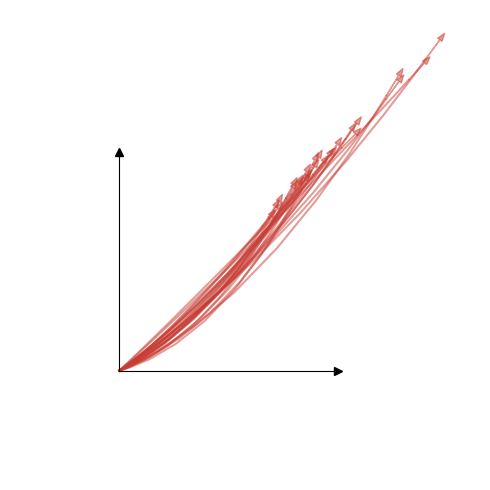

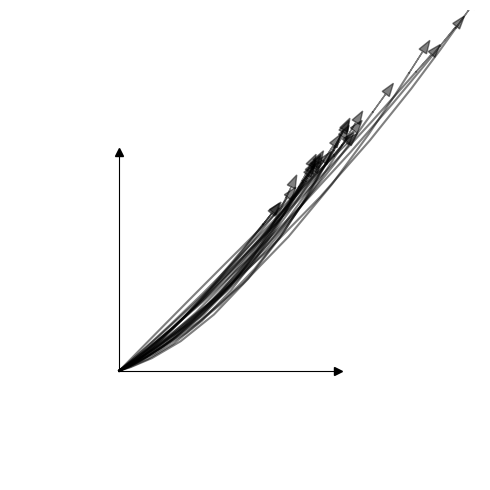

In [25]:
if rot_trajectories:

    data_file = data_files[0]
    
    dat = ML_loaded_data
    df1 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='PCA', loader_args=LD_args)
    df2 = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method='LQGCA', loader_args=LD_args)


    x = dat['spike_rates']
    xpca = x @ df1.iloc[0]['coef'][:, 0:jDIM]
    xdca = x @ df2.iloc[0]['coef']

    jpca1 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca1.fit(xpca)

    jpca2 = JPCA(n_components=jDIM, mean_subtract=False)
    jpca2.fit(xdca)

    xpca_j = jpca1.transform(xpca)
    xdca_j = jpca2.transform(xdca)

    xpca_j_mean = np.mean(xpca_j, 0).squeeze()
    xdca_j_mean = np.mean(xdca_j, 0).squeeze()



    ################################### PLOT CODE ##############################

    # Save as two separate figures
    fig1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 5))
    ax = [ax1, ax2]

    for i in range(0, 25):
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xpca_j[0, t0:t1],  sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xpca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center and normalize trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[8, 1], trajectory[8, 0])

        # Rotate *clockwise* by theta
        R = lambda theta: np.array([[np.cos(-1*theta), -np.sin(-theta)], \
                                    [np.sin(-theta), np.cos(theta)]])        
        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[1].plot(trajectory[:, 0], trajectory[:, 1], 'k', alpha=0.5)
        ax[1].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.08, color="k", alpha=0.5)
        
        """" 
        idx = dca_devorder[i]
        t0 = transition_times[idx][0]
        t1 = min(transition_times[idx][0] + 40, transition_times[idx][1])
        trajectory = gaussian_filter1d(xdca_j[0, t0:t1], sigma=5, axis=0)[:-3]
        """
        trajectory = gaussian_filter1d(xdca_j[i,:,:].squeeze(),  sigma=4, axis=0)

        # Center trajectories
        trajectory -= trajectory[0]
        #trajectory /= np.linalg.norm(trajectory)

        # Rotate trajectory so that the first 5 timesteps all go off at the same angle
        theta0 = np.arctan2(trajectory[8, 1], trajectory[8, 0])

        trajectory = np.array([R(theta0 - np.pi/4) @ t[0:2] for t in trajectory])

        ax[0].plot(trajectory[:, 0], trajectory[:, 1], '#c73d34', alpha=0.5)
        ax[0].arrow(trajectory[-1, 0], trajectory[-1, 1], 
                    trajectory[-1, 0] - trajectory[-2, 0], trajectory[-1, 1] - trajectory[-2, 1], 
                    head_width=0.05, color="#c73d34", alpha=0.5)

    _, p = scipy.stats.wilcoxon(maxim[:, 0, 2], maxim[:, 1, 2], alternative='less')
    print('Re p:%f' % p)


    ax[0].set_aspect('equal')   
    ax[1].set_aspect('equal')
    ax[1].set_xlim([-1, 3.3])
    ax[1].set_ylim([-1, 3.3])

    ax[0].set_xlim([-1, 3.3])
    ax[0].set_ylim([-1, 3.3])


    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')
    ax[0].spines['left'].set_position('zero')
    ax[0].spines['bottom'].set_position('zero')
    ax[0].plot(2, 0, ">k", clip_on=False)
    ax[0].plot(0, 2, "^k", clip_on=False)
    ax[0].spines['left'].set_bounds(0, 2)
    ax[0].spines['bottom'].set_bounds(0, 2)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')
    ax[1].spines['left'].set_position('zero')
    ax[1].spines['bottom'].set_position('zero')
    ax[1].spines['left'].set_bounds(0, 2)
    ax[1].spines['bottom'].set_bounds(0, 2)
    ax[1].plot(2, 0, ">k", clip_on=False)
    ax[1].plot(0, 2, "^k", clip_on=False)

    fig1.tight_layout()
    #fig1.savefig('%s/trajectories_a.pdf' % figpath, bbox_inches='tight', pad_inches=0)

    fig2.tight_layout()
    #fig2.savefig('%s/trajectories_b.pdf' % figpath, bbox_inches='tight', pad_inches=0)


# Next Plots: Trajectory Amplification 

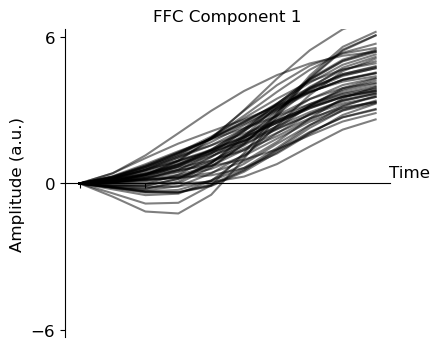

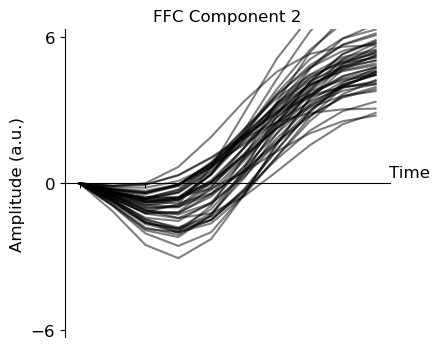

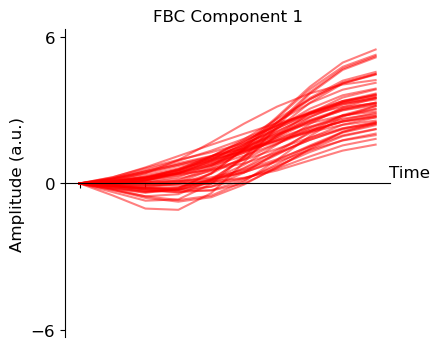

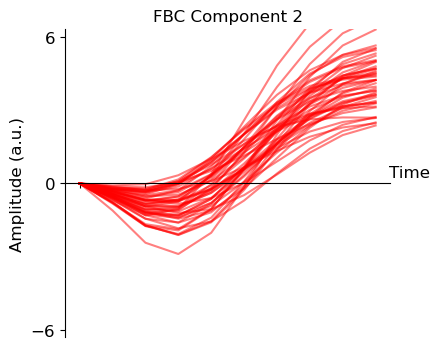

In [26]:
############## Trajectory Amplification #################
if run_dyn_range:

    dat = ML_loaded_data
    y = np.squeeze(dat['spike_rates'])

    colors = ['k', 'r']
    for j, dimreduc_method in enumerate(['PCA', 'LQGCA']):
        df_ = apply_df_filters(df_dimreduc, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method, loader_args=LD_args)

        #if dimreduc_method == 'LQGCA':
        #    df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

        assert(df_.shape[0] == 1)
        V = df_.iloc[0]['coef']
        if dimreduc_method == 'PCA':
            V = V[:, 0:DIM]        

        # Project data
        yproj = y @ V
        #yproj = np.array([yproj[t0:t0+40] for t0, t1 in dat['transition_times'] if t1 - t0 > 40])
        yproj = np.array([y_ - y_[0] for y_ in yproj])
        dY = np.concatenate(np.diff(yproj, axis=1), axis=0)
        Y_prestate = np.concatenate(yproj[:, :-1], axis=0)

        # Least squares
        A, _, _, _ = np.linalg.lstsq(Y_prestate, dY, rcond=None)
        _, s, _ = np.linalg.svd(A)
        #print('%s' % dimreduc_method + s)

        # Identify the directions in which there is the most amplification over multiple timesteps
        # Project the data along those directions and also record the amplification implied by the model
    
        # Iterate the lyapunov equation for 10 timesteps
        P = np.zeros((DIM, DIM))
        for _ in range(10):
            dP = A @ P + P @ A.T + np.eye(DIM)
            P += dP

        eig, U = np.linalg.eig(P)
        # eig, U = np.linalg.eig(scipy.linalg.expm(A.T) @ scipy.linalg.expm(A))
        eig = np.sort(eig)[::-1]
        U = U[:, np.argsort(eig)[::-1]]
        U = U[:, 0:2]
        # Plot smoothed, centered trajectories for all reaches in top 2 dimensions

        # Argsort by the maximum amplitude in the top 2 dimensions
        #trajectory = gaussian_filter1d(yproj, sigma=5, axis=1)
        trajectory = gaussian_filter1d(yproj, sigma=2, axis=1)

        trajectory -= trajectory[:, 0:1, :]
        trajectory = trajectory @ U
        dyn_range = np.max(np.abs(trajectory), axis=1)
        #dyn_range = np.max(np.abs(yproj @ U), axis=1)
        ordering = np.argsort(dyn_range, axis=0)[::-1]

        #t0 = trajectory[ordering[:, 0], :, 0]
        #t1 = trajectory[ordering[:, 1], :, 1]
        t0 = trajectory[:, :, 0]
        t1 = trajectory[:, :, 1]

        f1, a1 = plt.subplots(1, 1, figsize=(4.2, 4))
        f2, a2 = plt.subplots(1, 1, figsize=(4.2, 4))
        ax = [a1, a2]

        for i in range(min(50, t0.shape[0])):
            ax[0].plot(np.arange(len(t0[i])), t0[i], color=colors[j], alpha=0.5, linewidth=1.5)
            ax[1].plot(np.arange(len(t1[i])), t1[i], color=colors[j], alpha=0.5, linewidth=1.5)
            #ax[2*j].set_title(np.sum(eig))
            
        for a in ax:
            a.spines['bottom'].set_position('center')
            # Eliminate upper and right axes
            a.spines['right'].set_color('none')
            a.spines['top'].set_color('none')

            # Show ticks in the left and lower axes only
            a.xaxis.set_ticks_position('bottom')
            a.yaxis.set_ticks_position('left')

            a.set_xticks([0, 2])
            a.set_xticklabels([])
            a.tick_params(axis='both', labelsize=12)

            a.set_xlabel('Time (s)', fontsize=12)
            a.xaxis.set_label_coords(1.1, 0.56)
            
        # Set y scale according to the current yscale on PCA 0
        if j == 0:
            ylim_max = np.max(np.abs(t0[0])) + 0.25
            ylim = [-ylim_max, ylim_max]

        for a in ax:
            a.set_ylim(ylim)
            a.set_yticks([-int(ylim_max), 0, int(ylim_max)])
            a.set_ylabel('Amplitude (a.u.)', fontsize=12)

        if j == 0:
            ax[0].set_title('FFC Component 1', fontsize=12)
            ax[1].set_title('FFC Component 2', fontsize=12)
        else:
            ax[0].set_title('FBC Component 1', fontsize=12)
            ax[1].set_title('FBC Component 2', fontsize=12)

        #f1.tight_layout()
        #f2.tight_layout()
        #f1.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s1.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)
        #f2.savefig('/home/akumar/nse/neural_control/figs/amplification/%d_e_%s2.pdf' % (didx, dimreduc_method), bbox_inches='tight', pad_inches=0)


Im p:0.500000
0.5
0.5


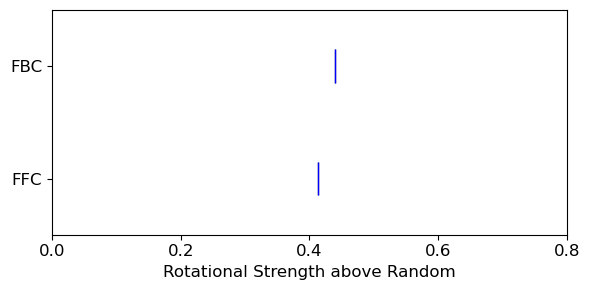

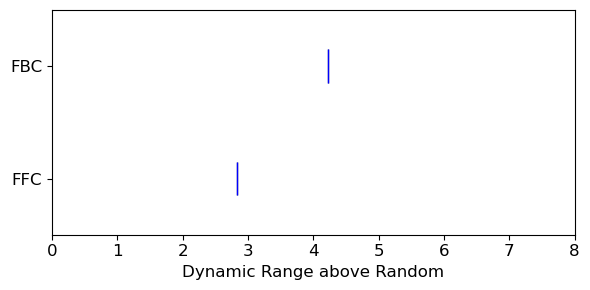

In [29]:
if boxplots:
    # Boxplots
    #fig, ax = plt.subplots(2, 1, figsize=(6, 3))
    fig0, ax0 = plt.subplots(figsize=(6, 3))

    medianprops = dict(linewidth=1, color='b')
    whiskerprops=dict(linewidth=0)
    #bplot = ax.boxplot([d_U[:, 2, 1], d_U[:, 3, 1]], patch_artist=True, medianprops=medianprops, notch=True, vert=False, showfliers=False)
    # Plot relative to the control...test for difference from zero

    # Center relative to random - per recording session
    mu = np.mean(maxim_control[..., 1], axis=1)
    sigma = np.std(maxim_control[..., 1], axis=1)
    r1 = maxim[:, 0, 1] - mu
    r2 = maxim[:, 1, 1] - mu

    bplot = ax0.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)
    
    

    # _, p = scipy.stats.wilcoxon(d_U[:, 2, 1], d_U[:, 3, 1])
    _, p = scipy.stats.wilcoxon(maxim[:, 0, 1], maxim[:, 1, 1], alternative='greater')
    print('Im p:%f' % p)

    # test that each is stochastically greater than the median random
    x1 = maxim[:, 0, 1] - np.median(maxim_control[..., 1].ravel())
    x2 = maxim[:, 1, 1] - np.median(maxim_control[..., 1].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')

    # _, p = scipy.stats.wilcoxon(maxim[:, 0, 2], maxim[:, 1, 2], alternative='less')
    # print('Re p:%f' % p)

    # Mutliple comparison adjusted test of maxim control against PCA and FCCA
    # _, p1 = scipy.stats.mannwhitneyu(maxim[:, 0, 1], maxim_control[..., 1].ravel(), alternative='greater')
    # _, p2 = scipy.stats.mannwhitneyu(maxim[:, 1, 1], maxim_control[..., 1].ravel(), alternative='greater')

    # print((p1, p2))

    method1 = 'FBC'
    method2 = 'FFC'

    ax0.set_yticklabels([method1, method2], fontsize=12)
    ax0.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax0.set_xlim([0, 0.8])
    ax0.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax0.set_xlabel('Rotational Strength above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax0.invert_yaxis()

    fig0.tight_layout()

    fig1, ax1 = plt.subplots(figsize=(6, 3))

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    whiskerprops = dict(linewidth=0)

    mu = np.mean(maxim_control[..., 2], axis=1)
    sigma = np.std(maxim_control[..., 2], axis=1)
    r1 = maxim[:, 0, 2] - mu
    r2 = maxim[:, 1, 2] - mu

    bplot = ax1.boxplot([r1, r2], patch_artist=True, 
                    medianprops=medianprops, notch=False, vert=False, showfliers=False, widths=[0.3, 0.3],
                    whiskerprops=whiskerprops, showcaps=False)

    x1 = maxim[:, 0, 2] - np.median(maxim_control[..., 2].ravel())
    x2 = maxim[:, 1, 2] - np.median(maxim_control[..., 2].ravel())

    _, p1 = scipy.stats.wilcoxon(x1, alternative='greater')
    _, p2 = scipy.stats.wilcoxon(x2, alternative='greater')
    print(p1)
    print(p2)

    method1 = 'FBC'
    method2 = 'FFC'

    ax1.set_yticklabels([method1, method2], fontsize=12)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax1.set_xlim([0, 8])
    ax1.tick_params(axis='both', labelsize=12)
    #ax.set_ylabel(r'$\sum_i Im(\lambda_i)$', fontsize=22)
    ax1.set_xlabel('Dynamic Range above Random', fontsize=12)
    #ax.set_title('****', fontsize=14)

    ax1.invert_yaxis()

    # fill with colors
    colors = ['red', 'black', 'blue']   
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)


    # ax.set_xlim([13, 0])

    fig1.tight_layout()
    #fig.savefig('%s/jpca_eig_bplot_wcontrol2.pdf' % figpath, pad_inches=1)